In [367]:
from bs4 import BeautifulSoup
import requests
import re
import json
import time
import random
import os
from collections import defaultdict
import dateutil.parser
import datetime
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp

In [76]:
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set()

# Steps
- Examine and explore the data   
  - Look at the data. If you can examine all of it in detail that is ideal. If dataset is very large, this may be unwieldy, so look at all of data in aggregated form (what is data type, how many entries are there, etc.) and examine a random subset in detail. Make sure the data is clean (remove NaN, for example) and meaningful (e.g., if the number of customers is negative, there is a problem).
     
  - Look at statistics: Correlation matrix, seaborn plots (to check for colinearity; compare what you see with human intuition) and probability distributions. Linear regression will typically see more success if the target variable has a fairly symmetric distribution (e.g., it might look close to a normal distribution). Look at the residual vs. y_pred plot for any weirdness (for example, due to bimodal distribution). 
  
- Baselining. Look at one feature (you might get lucky and this is THE feature needed to explain your observations). You can see the fit immediately from the seaborn plot. Run statsmodels or sklearn to look at R^2, etc.
- Expand model. Run it with a few features (3 or 4), so it is still humanly interpretable. Plot distribution of target variable, errors vs. predicted value to see if non-linearity or heteroskedasticity are an issue. Check fit of the model. Possibly run statsmodels to calculate p-values and see if they correspond to your intuition.
- Complete model. Run with all features and run same diagnostics. Do you need all of the features or can you discard some of them? Are the coefficients (betas) statistically significant? Make sure you understand the diagnostics to know if your p-values are trustworthy or not.
- Validate model. Set up a validation scheme, preferably cross-validation if you have the computational resources as it is more robust. Using your validation scheme, you can perform iterative feature selection/expansion/engineering and model complexity adjustments in order to complete the next 2 steps.
- Challenge model. Do you need more complexity or less? Do you need a fancier model (nonlinear, additional feature engineering / transformations e.g. polynomial)? Hopefully at this point you have an understanding of where you need to go by knowing the bias vs. variance tradeoff.
- Refine model. Add or remove complexity (using a more sophisticated model or making your model more conservative by using regularization). Compare with unrefined model (error vs. y_pred, R^2, MAE, RMSE). Use regularization to fine tune model (Ridge, Lasso; Lasso may eliminate coefficients that you included at first).
- Test model. How does your final, refined model perform on out-of-sample data? If it does well, hurray! If not, linear regression (with this data set) may not be the answer and you have to move to find more features, more data, or more complex models that are harder to interpret.



In [291]:
def model(X, y, one_x=False):
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25)

    #
    # Linear
    # score on train to get upper bound
    lm1 = LinearRegression()
    lm1.fit(X_cv, y_cv)
    print("Best possible Linear Regression R^2:", lm1.score(X_cv, y_cv))

    lm2 = LinearRegression()
    cv_scores = cross_val_score(lm2, X_cv, y_cv, # estimator, features, target
                                  cv=5, # number of folds 
                                  scoring='r2') # scoring metric
    print('K-Fold CV Linear Regression R^2:',  cv_scores, "mean: ", np.mean(cv_scores))
   
    
    lm2.fit(X_cv,y_cv)
    print(f'Linear Regression test R^2: {lm2.score(X_test, y_test):.3f}')
    print(lm2.intercept_)
    if one_x == False:
        pp.pprint(list(zip(X.columns, lm2.coef_)))
    
    if one_x:
        return
    #
    #
    # Ridge
    #Feature scaling for train, val, and test so that we can run our ridge model on each
    scaler = StandardScaler()

    X_cv_scaled = scaler.fit_transform(X_cv.values)
    X_test_scaled = scaler.transform(X_test.values)

    lm_reg1 = Ridge(alpha=1)
    lm_reg1.fit(X_cv_scaled, y_cv)
    print("Best possible Ridge Regression R^2:", lm_reg1.score(X_cv_scaled, y_cv))
    
    lm_reg2 = Ridge(alpha=1)
    cv_scores = cross_val_score(lm_reg2, X_cv_scaled, y_cv, cv=5, scoring='r2')
    print('K-fold CV Ridge Regression R^2: ',  cv_scores, "mean: ", np.mean(cv_scores)) 
    lm_reg2.fit(X_cv_scaled,y_cv)
    print(f'Ridge Regression test R^2: {lm_reg2.score(X_test_scaled, y_test):.3f}')
    print(lm_reg2.intercept_)
    pp.pprint(list(zip(X.columns, lm_reg2.coef_)))

    #
    #
    # Poly
    poly = PolynomialFeatures(degree=2) 

    X_cv_poly = poly.fit_transform(X_cv.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly1 = LinearRegression()
    lm_poly1.fit(X_cv_poly, y_cv)
    print("Best possible Polynomial Regression R^2:", lm_poly1.score(X_cv_poly, y_cv))
    
    lm_poly2 = LinearRegression()
    cv_scores =  np.mean(cross_val_score(lm_poly2, X_cv_poly, y_cv, cv=5, scoring='r2')) 
    print('K-fold CV Polynomial Regression R^2: ',  cv_scores, "mean: ", np.mean(cv_scores)) 
    lm_poly2.fit(X_cv_poly,y_cv)
    print(f'Polynomial Regression test R^2: {lm_poly2.score(X_test_poly, y_test):.3f}')
    print(lm_poly2.intercept_)
    pp.pprint(list(zip(poly.get_feature_names(), lm_poly2.coef_)))
    
    lass = LassoCV()
    p2 = PolynomialFeatures(degree=2)
    X_cv_poly2 = p2.fit_transform(X_cv.values)
    X_test_poly2 = p2.transform(X_test.values)
    lass.fit(X_cv_poly2,y_cv)
    print('Polynomial Lasso Regression CV R^2: ',  lass.score(X_cv_poly2,y_cv))#, "mean: ", np.mean(cv_scores)) 
    print(f'Polynomial Lasso Regression test R^2: {lass.score(X_test_poly, y_test):.3f}')
    #lass.fit(X_cv_poly,y_cv)
    #print(f'Polynomial Regression test R^2: {lass.score(X_test_poly, y_test):.3f}')

    pp.pprint(list(zip(p2.get_feature_names(), lass.coef_)))

    
    return (lm2, lm_reg2, lm_poly2, lass)


In [146]:
df = pd.read_pickle('../resources/pickles/kickstarter_cat_34.pkl')

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11607 entries, 0 to 11606
Data columns (total 33 columns):
backers_count               11607 non-null int64
base_id                     11607 non-null int64
blurb                       11607 non-null object
category_id                 11607 non-null int64
category_parent_id          11607 non-null int64
category_slug               11607 non-null object
converted_pledged_amount    11607 non-null int64
country                     11607 non-null object
created_at                  11607 non-null datetime64[ns]
creator_id                  11607 non-null int64
creator_url                 11607 non-null object
deadline                    11607 non-null datetime64[ns]
fx_rate                     11607 non-null float64
goal                        11607 non-null float64
is_flagged_spotlight        11607 non-null bool
launched_at                 11607 non-null datetime64[ns]
location_country            11604 non-null object
location_id            

In [148]:
df.drop_duplicates(inplace=True, subset='profile_project_id')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10563 entries, 0 to 11606
Data columns (total 33 columns):
backers_count               10563 non-null int64
base_id                     10563 non-null int64
blurb                       10563 non-null object
category_id                 10563 non-null int64
category_parent_id          10563 non-null int64
category_slug               10563 non-null object
converted_pledged_amount    10563 non-null int64
country                     10563 non-null object
created_at                  10563 non-null datetime64[ns]
creator_id                  10563 non-null int64
creator_url                 10563 non-null object
deadline                    10563 non-null datetime64[ns]
fx_rate                     10563 non-null float64
goal                        10563 non-null float64
is_flagged_spotlight        10563 non-null bool
launched_at                 10563 non-null datetime64[ns]
location_country            10560 non-null object
location_id            

In [82]:
df.describe()

backers_count       base_id  category_id  category_parent_id  \
count   10563.000000  1.056300e+04      10563.0             10563.0   
mean      865.605699  1.073541e+09         34.0                12.0   
std      3229.067558  6.216240e+08          0.0                 0.0   
min         1.000000  3.923500e+04         34.0                12.0   
25%        96.000000  5.299131e+08         34.0                12.0   
50%       252.000000  1.083914e+09         34.0                12.0   
75%       720.000000  1.610657e+09         34.0                12.0   
max    219382.000000  2.147389e+09         34.0                12.0   

       converted_pledged_amount    creator_id       fx_rate          goal  \
count              1.056300e+04  1.056300e+04  10563.000000  1.056300e+04   
mean               6.746052e+04  1.079246e+09      1.002523  1.243621e+04   
std                2.945993e+05  6.232037e+08      0.174899  4.469103e+04   
min                8.000000e+00  4.223010e+05      0.009313  1.000000e+00   
25%                4.003000e+03  5.458201e+08      1.000000  1.000000e+03   
50%                1.242200e+04  1.081689e+09      1.000000  5.000000e+03   
75%                3.776250e+04  1.620165e+09      1.000000  1.241350e+04   
max                1.239314e+07  2.146601e+09      1.229370  2.200000e+06   

        location_id  percent_funded       pledged  profile_project_id  \
count  1.056000e+04    1.056300e+04  1.056300e+04        1.056300e+04   
mean   2.797428e+06    2.275317e+03  7.436373e+04        2.700932e+06   
std    5.037582e+06    4.640750e+04  3.161897e+05        9.339071e+05   
min    3.210000e+02    1.000000e+02  8.000000e+00        1.484000e+03   
25%    7.790630e+05    1.516750e+02  4.002770e+03        2.216520e+06   
50%    2.401184e+06    2.985000e+02  1.242700e+04        2.975688e+06   
75%    2.473224e+06    6.942050e+02  3.956375e+04        3.423805e+06   
max    5.604400e+07    3.284300e+06  1.239314e+07        3.819693e+06   

        usd_pledged  
count  1.056300e+04  
mean   6.751367e+04  
std    2.948168e+05  
min    8.000000e+00  
25%    4.009899e+03  
50%    1.242700e+04  
75%    3.792578e+04  
max    1.239314e+07

In [83]:
df.head()

backers_count     base_id  \
0            181   592551458   
1            147  1573096498   
2             24   733303305   
3             67   365147754   
4            247   654422435   

                                               blurb  category_id  \
0  More High Fantasy inspired soundscapes for gam...           34   
1  A card game of deduction and dirty tricks for ...           34   
2  The next unit in my Orc range, this time the B...           34   
3  Resin wargaming models scaled to fit with 28 t...           34   
4  d&D sucks and this is the GREATEst game of ALL...           34   

   category_parent_id         category_slug  converted_pledged_amount country  \
0                  12  games/tabletop games                      6734      US   
1                  12  games/tabletop games                      3347      US   
2                  12  games/tabletop games                      1440      GB   
3                  12  games/tabletop games                      4430      GB   
4                  12  games/tabletop games                      1824      US   

           created_at  creator_id  \
0 2014-02-21 02:35:10  1766442648   
1 2014-10-17 13:32:54   256517189   
2 2014-10-13 09:54:06   231062375   
3 2014-10-29 08:58:26   179741323   
4 2014-08-23 04:25:19  1430411066   

                                        creator_url            deadline  \
0  https://www.kickstarter.com/profile/strangelette 2014-11-22 19:36:51   
1     https://www.kickstarter.com/profile/256517189 2014-11-19 19:00:00   
2     https://www.kickstarter.com/profile/231062375 2014-11-18 08:57:18   
3     https://www.kickstarter.com/profile/179741323 2014-11-13 15:43:08   
4    https://www.kickstarter.com/profile/1430411066 2014-11-12 20:01:00   

   fx_rate    goal  is_flagged_spotlight         launched_at location_country  \
0  1.00000  1000.0                  True 2014-10-23 18:36:51    United States   
1  1.00000  1000.0                  True 2014-10-28 14:10:48    United States   
2  1.22937   600.0                  True 2014-10-19 07:57:18   United Kingdom   
3  1.22937   500.0                  True 2014-10-29 14:43:08   United Kingdom   
4  1.00000    50.0                  True 2014-10-08 17:35:17    United States   

   location_id          location_name  \
0    2466256.0            Orlando, FL   
1    2396300.0       East Walpole, MA   
2   12695981.0  Stevenage Borough, UK   
3      30720.0         Nottingham, UK   
4    2490383.0            Seattle, WA   

                                                name  percent_funded  pledged  \
0  Epic Fantasy Soundtracks II: Tabletop Gaming S...      673.400000   6734.0   
1                                Truths Too Terrible      334.700000   3347.0   
2                         Orc Bowmen 28mm miniatures      153.333333    920.0   
3                 Minimus Squat's Bounty Hunter Crew      561.800000   2809.0   
4                                50 sHAdes of VORpal     3648.000000   1824.0   

                                profile_external_url  profile_project_id  \
0                                               None              899458   
1        http://www.amazon.com/gp/product/B00UZLJ6LS             1447772   
2                                               None             1435632   
3                                               None             1476869   
4  http://www.drivethrurpg.com/product/211137/50-...             1310498   

  profile_state profile_state_changed_at  \
0      inactive      2015-03-09 15:44:09   
1        active      2015-03-23 17:37:55   
2      inactive      2015-03-09 15:44:39   
3      inactive      2015-03-09 15:44:41   
4        active      2017-05-05 07:46:07   

                                                slug  staff_pick       state  \
0  epic-fantasy-soundtracks-ii-tabletop-gaming-so...       False  successful   
1                                truths-too-terrible       False  successful   
2                         orc-bowmen-28mm-miniature

In [380]:
df_year = df.copy()
df_year['deadline_year'] = df_year['deadline'].dt.year
df_year['sum_usd_pledged'] = df_year.groupby('deadline_year')['usd_pledged'].transform(np.sum)
df_year

backers_count     base_id  \
0                181   592551458   
1                147  1573096498   
2                 24   733303305   
3                 67   365147754   
4                247   654422435   
5                155  1258067906   
6                113  1240888919   
7                 63  1507777384   
8                 89   774432866   
9                169   748622269   
10                69   173933060   
11                81  1111165988   
12                56   644238624   
13               113   206219682   
14                88  1347154604   
15                43  1766731940   
16               178  2082391356   
17               140   515441803   
18               176  1783590596   
19               193  1416546889   
20               154   562445400   
21                55   250852404   
22                42    29831455   
23               104   269659790   
24                47   347662156   
25               130  1507443676   
26                92  1190170622   
27               148    56720251   
28               208  1499561145   
29               121   990866734   
30                89  1352848890   
31                60  1748224626   
32               184   307314107   
33               171  1226911765   
34               179  1658866594   
35               135    59944724   
36               153  1342622344   
37               560   234120504   
38              1037   172629019   
39               273   848637923   
40               759  1570091188   
41               381   359973103   
42               252   741936025   
43              1221  1283390682   
44               598   424471059   
45               363  1553042237   
46               761   679379184   
47               271   578987856   
48                55  1815503553   
49               203  1369393236   
50                74   710325944   
51                52  2100946661   
52               121  1597528856   
53                59   257458884   
54               661   468273255   
55               160   741295117   
56               463   469972018   
57                81  1251447127   
58               254   719877285   
59               614   306888567   
60               540   238383224   
61               662  1405965141   
62               500   506045904   
63              2016  1820017959   
64               236  1094769825   
65               550  1696486672   
66              1241   490057841   
67              1980  1179868022   
68               207   874455261   
69               862   554812469   
70               110   711736039   
71               476  2077786014   
72               139   309180021   
73                70   767700668   
74               139    82992950   
75               322  2019578736   
76                25  1335425030   
77                78    81242412   
78               162  1131471755   
79               204   293365888   
80                46  1494442317   
81               103   502157119   
82               256  2047826397   
83               141   796348624   
84              1813   227236749   
85              1470    92423606   
86               633   646654187   
87              1294    51756958   
88                85   320648201   
89               104   795239319   
90               178   654738316   
91               217  1940464944   
92               542  1630617587   
93               526   693874559   
94               196  1989711271   
95               149   920251818   
96               175  1755264077   
97               174  1957824254   
98                17   219162195   
99                62   696707936   
100               45   736925361   
101              119  1895567338   
102               20  1399954466   
103              382  2023039486   
104              210  2011610825   
105              296  1954371618   
106               41  1696231546   
107               57  1543548579   
108               23  1639568903   
109               42  2134816060   
110        

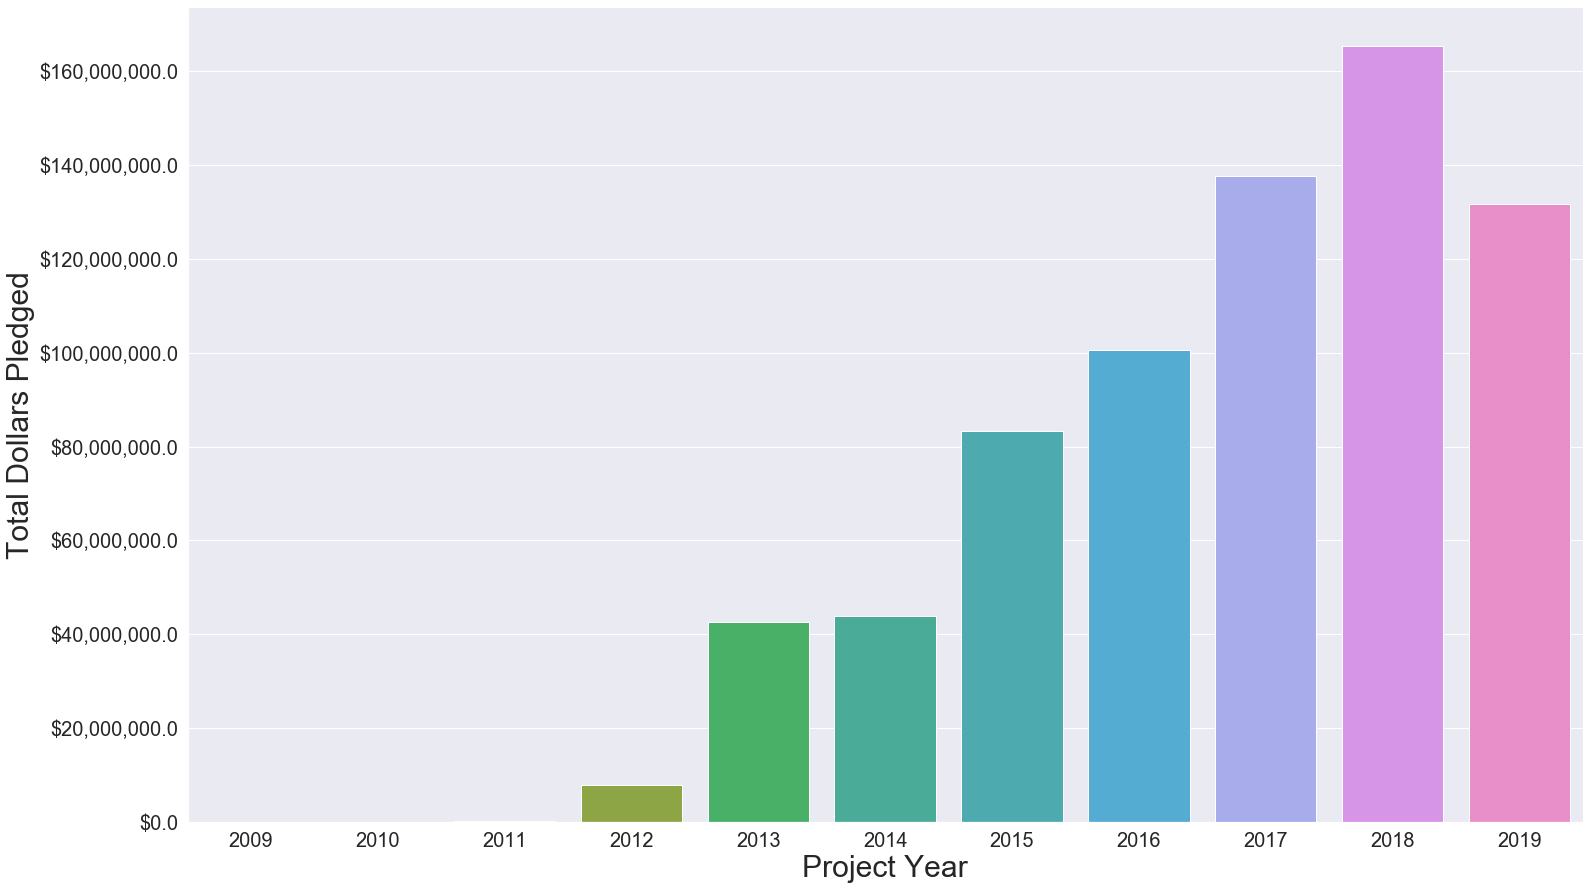

In [411]:
# sns.lmplot(x="deadline", y="usd_pledged",data=df,  fit_reg=False, scatter_kws={"s": z*1000})
# sns.relplot(x="deadline", y="mpg", hue="origin", size="weight",
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=mpg)
import matplotlib.ticker as ticker


plt.figure(figsize=(25,15))
#sns.scatterplot(x="deadline",  y="usd_pledged", data=df_year, alpha=.7)
ax = sns.barplot(x="deadline_year",  y="sum_usd_pledged", data=df_year)
# control x and y limits
#plt.ylim(0, None)
#plt.xlim([datetime.date(2009,1,1), datetime.date(2020,1,1)])

vals = ax.get_yticks()
ax.set_yticklabels(['${:,}'.format(x) for x in vals])
ax.set_xlabel("Project Year",fontsize=30)
ax.set_ylabel("Total Dollars Pledged",fontsize=30)
ax.tick_params(labelsize=20)
ax.figure.savefig("output.png")




In [374]:
df_year = df.copy()
df_year['deadline_year'] = df_year['deadline'].dt.year
df_year.groupby('deadline_year')['usd_pledged'].sum()

deadline_year
2009    1.244000e+03
2010    4.816000e+03
2011    2.113490e+05
2012    7.964608e+06
2013    4.268931e+07
2014    4.402390e+07
2015    8.322433e+07
2016    1.005427e+08
2017    1.375075e+08
2018    1.653399e+08
2019    1.316372e+08
Name: usd_pledged, dtype: float64

- Examine and explore the data   
  - Look at the data. If you can examine all of it in detail that is ideal. If dataset is very large, this may be unwieldy, so look at all of data in aggregated form (what is data type, how many entries are there, etc.) and examine a random subset in detail. Make sure the data is clean (remove NaN, for example) and meaningful (e.g., if the number of customers is negative, there is a problem).
     
  - Look at statistics: Correlation matrix, seaborn plots (to check for colinearity; compare what you see with human intuition) and probability distributions. Linear regression will typically see more success if the target variable has a fairly symmetric distribution (e.g., it might look close to a normal distribution). Look at the residual vs. y_pred plot for any weirdness (for example, due to bimodal distribution). 
  

# Baselining
Look at one feature (you might get lucky and this is THE feature needed to explain your observations). You can see the fit immediately from the seaborn plot. Run statsmodels or sklearn to look at R^2, etc.

In [303]:
ks_df = df[[
    'profile_project_id',
    'backers_count',   
    'usd_pledged',
    'percent_funded'
   ]].dropna()
ks_df.sample(20)

profile_project_id  backers_count    usd_pledged  percent_funded
972               1000573           1926   77671.990000      517.813267
11369             3069384            196   12576.807502      318.360000
6779              3174728            264   17216.000000      196.754286
8395              2131409            150    9417.394198      197.725000
7179              1986845            252   17032.665276      154.820000
4207              3236033           3697  106994.250000      427.977000
1462              2674904            298   13116.000000      109.300000
8903              3375305            162    7505.000000      115.461538
1647              3732377             39    1233.715424     1786.320000
7504              2474311            397   28964.386476      187.620000
2732              2252441             87    2486.089498      138.240000
2398              3397348            142   11768.000000      784.533333
6473              3055891            834  101328.500000     1013.285000
3872              3418603            338   15440.032893      267.040000
11051              899900             67     359.000000      224.375000
10246             2344053             86    6650.520000      332.526000
10251             3300921            176   12154.000000      110.490909
3893              2931350            209    5764.000000      115.280000
1411              3482282           2946  422647.340000      422.647340
7020              3679301            334   16505.000000     1100.333333

In [304]:
ks_df.describe()

profile_project_id  backers_count   usd_pledged  percent_funded
count        1.056300e+04   10563.000000  1.056300e+04    1.056300e+04
mean         2.700932e+06     865.605699  6.751367e+04    2.275317e+03
std          9.339071e+05    3229.067558  2.948168e+05    4.640750e+04
min          1.484000e+03       1.000000  8.000000e+00    1.000000e+02
25%          2.216520e+06      96.000000  4.009899e+03    1.516750e+02
50%          2.975688e+06     252.000000  1.242700e+04    2.985000e+02
75%          3.423805e+06     720.000000  3.792578e+04    6.942050e+02
max          3.819693e+06  219382.000000  1.239314e+07    3.284300e+06

In [305]:
ks_df.drop('profile_project_id', axis =1).corr()

backers_count  usd_pledged  percent_funded
backers_count        1.000000     0.738528        0.024402
usd_pledged          0.738528     1.000000        0.015874
percent_funded       0.024402     0.015874        1.000000

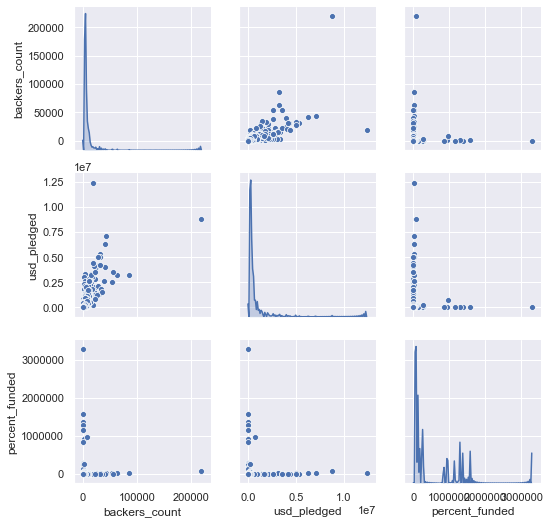

In [306]:
sns.pairplot(ks_df.drop('profile_project_id', axis =1), diag_kind='kde')

## Extreme dollars raised

In [154]:
ks_df.sort_values('usd_pledged', ascending=False)

profile_project_id  backers_count   usd_pledged
3146              2752819          19264  1.239314e+07
6518              1577596         219382  8.782572e+06
2163              3134570          43733  7.072757e+06
862               3510927          41939  6.297405e+06
5783              1982424          31178  5.342789e+06
10402             3010038          27236  5.004615e+06
10339             3717678          32582  4.995435e+06
10394             3244557          19303  4.403198e+06
2161              3194341          30553  4.248834e+06
10404             2892230          31262  4.228060e+06
9933              1926143          20915  4.079205e+06
955               3704376          23986  4.013731e+06
3144              2921056          40642  3.999796e+06
9929              2539033          22361  3.560643e+06
10340             3743270          55024  3.538065e+06
963               3348042          18486  3.352209e+06
6519              1591783          16038  3.327757e+06
867               3424151           3106  3.317658e+06
5787              2334346          63758  3.246589e+06
5778              2712207          85581  3.215680e+06
8251               696992          14964  3.169611e+06
3141              3016888           2897  3.055118e+06
3138              3084450          16200  3.051004e+06
8247              1071660          12011  2.849064e+06
962               3038175          23325  2.810298e+06
6516              1751035          13465  2.730366e+06
3147              2644859          13635  2.669010e+06
2152              3409738          38335  2.650876e+06
5780              2480645           3364  2.592232e+06
10337             3412312          11277  2.586422e+06
10341             3748254          11747  2.575193e+06
859               3524769          53643  2.559458e+06
958               3414605          15831  2.412286e+06
6517              1697384           2719  2.359260e+06
8256               486413           8944  2.255018e+06
3142              2905567          12439  2.210165e+06
2162              3126691           9987  2.152285e+06
8249               897443           3950  2.140851e+06
2160              3295221          28918  2.121465e+06
865               3439238          22860  2.069101e+06
961               2361709           9800  2.052791e+06
8257               253044           5410  2.049721e+06
2159              3323805          18301  2.045463e+06
960               3353735          12716  2.028473e+06
8255               479247           5398  1.908156e+06
3137              3101571          33720  1.865141e+06
6513              2016258          17739  1.810295e+06
861               3472982          12428  1.806651e+06
956               3426438           9838  1.791892e+06
5784              2391849           1688  1.781737e+06
10338             3766564          11674  1.735944e+06
858               3553150          20886  1.726461e+06
6510              2209598           9991  1.710714e+06
10398             3078020           9040  1.690466e+06
9935              1669085           8396  1.546270e+06
5786              2343727           9982  1.518322e+06
952               3747516          11808  1.492714e+06
6509              2122342          34565  1.479047e+06
954               3698265           9731  1.472939e+06
10395             3237920          10227  1.469489e+06
6515              2096287          10136  1.464490e+06
8254               481795           5342  1.442312e+06
5779              2661331           9566  1.438294e+06
866               3284983          23338  1.421904e+06
8252               589788           4389  1.403981e+06
6514              2099201          12103  1.370334e+06
856               3703406          26004  1.367901e+06
5781              2498954          30546  1.353024e+06
5782              2468522          12187  1.351142e+06
8250               735932           4727  1.341305e+06
5785              2158883          11483  1.316813e+06
2158              3033007           8364  1.311

In [155]:
df.loc[df['profile_project_id']==2752819]

backers_count    base_id  \
3146          19264  545070200   

                                                  blurb  category_id  \
3146  A cooperative nightmare horror game experience...           34   

      category_parent_id         category_slug  converted_pledged_amount  \
3146                  12  games/tabletop games                  12393139   

     country          created_at  creator_id  \
3146      US 2016-11-09 16:16:44  2121023188   

                                    creator_url            deadline  fx_rate  \
3146  https://www.kickstarter.com/profile/poots 2017-01-07 23:00:00      1.0   

          goal  is_flagged_spotlight         launched_at location_country  \
3146  100000.0                  True 2016-11-25 05:01:41    United States   

      location_id location_name                        name  percent_funded  \
3146    2411081.0  Glendale, NY  Kingdom Death: Monster 1.5     12393.13969   

          pledged                               profile_external_url  \
3146  12393139.69  https://shop.kingdomdeath.com/collections/in-s...   

      profile_project_id profile_state profile_state_changed_at  \
3146             2752819        active      2017-01-09 21:29:48   

                          slug  staff_pick       state    state_changed_at  \
3146  kingdom-death-monster-15        True  successful 2017-01-07 23:00:03   

                                            url_project  \
3146  https://www.kickstarter.com/projects/poots/kin...   

                                            url_rewards  usd_pledged  
3146  https://www.kickstarter.com/projects/poots/kin...  12393139.69

## Extreme number of backers

In [156]:
ks_df.sort_values('backers_count', ascending=False)

profile_project_id  backers_count   usd_pledged
6518              1577596         219382  8.782572e+06
5778              2712207          85581  3.215680e+06
5787              2334346          63758  3.246589e+06
10340             3743270          55024  3.538065e+06
859               3524769          53643  2.559458e+06
2163              3134570          43733  7.072757e+06
862               3510927          41939  6.297405e+06
3144              2921056          40642  3.999796e+06
2152              3409738          38335  2.650876e+06
6509              2122342          34565  1.479047e+06
3137              3101571          33720  1.865141e+06
10339             3717678          32582  4.995435e+06
10404             2892230          31262  4.228060e+06
5783              1982424          31178  5.342789e+06
2161              3194341          30553  4.248834e+06
5781              2498954          30546  1.353024e+06
2160              3295221          28918  2.121465e+06
10402             3010038          27236  5.004615e+06
856               3703406          26004  1.367901e+06
10335             3762017          25545  1.268878e+06
955               3704376          23986  4.013731e+06
11288             3259146          23425  8.544830e+05
866               3284983          23338  1.421904e+06
962               3038175          23325  2.810298e+06
865               3439238          22860  2.069101e+06
9929              2539033          22361  3.560643e+06
9933              1926143          20915  4.079205e+06
858               3553150          20886  1.726461e+06
2154              3380952          20743  1.204970e+06
10394             3244557          19303  4.403198e+06
3146              2752819          19264  1.239314e+07
9376              3529265          18768  2.498991e+05
963               3348042          18486  3.352209e+06
2159              3323805          18301  2.045463e+06
6513              2016258          17739  1.810295e+06
3038              2727045          17152  5.898160e+05
4213              3179804          16531  4.651011e+05
3138              3084450          16200  3.051004e+06
6519              1591783          16038  3.327757e+06
7459              3483184          16029  9.400575e+05
958               3414605          15831  2.412286e+06
8251               696992          14964  3.169611e+06
8803              3449900          14904  5.455311e+05
857               3667982          14604  1.001086e+06
2510              2228017          14579  4.686291e+05
5988              3294678          14351  6.542481e+05
10205             2573940          14160  5.759267e+05
7010              3247015          14002  5.873400e+05
4456              3422006          13825  4.987515e+05
9629               591190          13765  6.312306e+05
3143              2952435          13699  1.289598e+06
3147              2644859          13635  2.669010e+06
6516              1751035          13465  2.730366e+06
9992              3647128          13398  6.048150e+05
2260              2533219          12798  5.262748e+05
960               3353735          12716  2.028473e+06
6166              1491439          12458  4.116933e+05
3142              2905567          12439  2.210165e+06
861               3472982          12428  1.806651e+06
2157              3313622          12257  1.024775e+06
5782              2468522          12187  1.351142e+06
3140              3022031          12159  1.100212e+06
6514              2099201          12103  1.370334e+06
10336             3444172          12056  1.142512e+06
3203              3147341          12012  7.660852e+05
8247              1071660          12011  2.849064e+06
1090              3792682          11931  9.892899e+05
10345             3673334          11900  1.098416e+06
4174              2779624          11867  4.032423e+05
6931               847360          11858  5.851220e+05
952               3747516          11808  1.492714e+06
10341             3748254          11747  2.575

In [157]:
df.loc[df['profile_project_id']==1577596]

backers_count     base_id  \
6518         219382  1955357092   

                                                  blurb  category_id  \
6518  This is a card game for people who are into ki...           34   

      category_parent_id         category_slug  converted_pledged_amount  \
6518                  12  games/tabletop games                   8782571   

     country          created_at  creator_id  \
6518      US 2014-12-15 08:39:54  1281334714   

                                      creator_url            deadline  \
6518  https://www.kickstarter.com/profile/elanlee 2015-02-20 02:00:00   

      fx_rate     goal  is_flagged_spotlight         launched_at  \
6518      1.0  10000.0                  True 2015-01-20 18:00:19   

     location_country  location_id    location_name               name  \
6518    United States    2442047.0  Los Angeles, CA  Exploding Kittens   

      percent_funded     pledged  \
6518      87825.7199  8782571.99   

                                   profile_external_url  profile_project_id  \
6518  https://www.kickstarter.com/projects/elanlee/t...             1577596   

     profile_state profile_state_changed_at               slug  staff_pick  \
6518        active      2015-03-28 22:11:30  exploding-kittens        True   

           state    state_changed_at  \
6518  successful 2015-02-20 02:01:19   

                                            url_project  \
6518  https://www.kickstarter.com/projects/elanlee/e...   

                                            url_rewards  usd_pledged  
6518  https://www.kickstarter.com/projects/elanlee/e...   8782571.99

## Remove these two extreme successes

In [307]:
ks_df_1=ks_df[ks_df['profile_project_id'] != 1577596]
ks_df_1=ks_df_1[ks_df_1['profile_project_id'] != 2752819]

In [308]:
ks_df_1.drop('profile_project_id', axis =1).corr()

backers_count  usd_pledged  percent_funded
backers_count        1.000000     0.809134        0.016620
usd_pledged          0.809134     1.000000        0.011362
percent_funded       0.016620     0.011362        1.000000

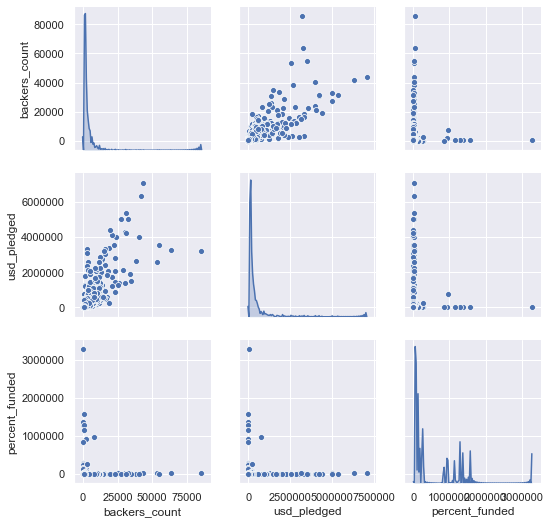

In [309]:
sns.pairplot(ks_df_1.drop('profile_project_id', axis =1), diag_kind='kde')

### Model

In [266]:
X1 = ks_df_1['backers_count'].values.reshape(-1, 1)
y1 = ks_df_1['usd_pledged']
model(X1, y1, one_x = True)

Best possible Linear Regression R^2: 0.6325527587369357
K-Fold CV Linear Regression R^2: [0.69113899 0.33421375 0.72383605 0.54509802 0.65777776] mean:  0.5904129149721966
Linear Regression test R^2: 0.722
-3137.9589679018245


In [310]:
X1 = ks_df_1['backers_count'].values.reshape(-1, 1)
y1 = ks_df_1['percent_funded']
model(X1, y1, one_x = True)

Best possible Linear Regression R^2: 0.00021188787914894203
K-Fold CV Linear Regression R^2: [ 0.00071474 -0.23456317 -0.16012145 -0.000338   -0.00229644] mean:  -0.07932086553312494
Linear Regression test R^2: -0.035
2406.213667529698


## Backers count is a strong proxy for dollars raised. 
However, I don't want to use this features, as it's pretty obvious, and not information that a creator has at their disposal

# Expand model. 
Run it with a few features (3 or 4), so it is still humanly interpretable. Plot distribution of target variable, errors vs. predicted value to see if non-linearity or heteroskedasticity are an issue. Check fit of the model. Possibly run statsmodels to calculate p-values and see if they correspond to your intuition.

In [311]:
df_2 = df.copy()
df_2['staff_pick'] = (df_2['staff_pick']).astype(int)
df_2['is_flagged_spotlight'] = (df_2['is_flagged_spotlight']).astype(int)
df_2['launch_day'] = (df_2['launched_at'].dt.day_name())
df_2['deadline_day'] = (df_2['deadline'].dt.day_name())
df_2['duration'] = df_2['deadline'] - df_2['launched_at']
df_2['duration_days'] = df_2['duration'].dt.days
df_2=df_2[df_2['profile_project_id'] != 1577596]
df_2=df_2[df_2['profile_project_id'] != 2752819]
df_2.head(2)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10561 entries, 0 to 11606
Data columns (total 37 columns):
backers_count               10561 non-null int64
base_id                     10561 non-null int64
blurb                       10561 non-null object
category_id                 10561 non-null int64
category_parent_id          10561 non-null int64
category_slug               10561 non-null object
converted_pledged_amount    10561 non-null int64
country                     10561 non-null object
created_at                  10561 non-null datetime64[ns]
creator_id                  10561 non-null int64
creator_url                 10561 non-null object
deadline                    10561 non-null datetime64[ns]
fx_rate                     10561 non-null float64
goal                        10561 non-null float64
is_flagged_spotlight        10561 non-null int64
launched_at                 10561 non-null datetime64[ns]
location_country            10558 non-null object
location_id           

In [312]:
df_2[['launched_friday', 'launched_monday', 'launched_saturday','launched_sunday', 
    'launched_thursday', 'launched_tuesday', 'launched_wednesday'
   ]] = pd.get_dummies(df_2['launch_day'],drop_first=False)


In [313]:
df_2[['deadline_friday', 'deadline_monday', 'deadline_saturday','deadline_sunday', 
    'deadline_thursday', 'deadline_tuesday', 'deadline_wednesday'
   ]] = pd.get_dummies(df_2['deadline_day'],drop_first=False)


In [318]:
ks_df_2 = df_2[[
#     'launched_monday',
#     'launched_tuesday',
#     'launched_wednesday', 
#     'launched_thursday', 
#     'launched_friday', 
#     'launched_saturday', 
#     'launched_sunday',
#     'deadline_monday',
#     'deadline_tuesday',
#     'deadline_wednesday', 
#     'deadline_thursday', 
#     'deadline_friday', 
#     'deadline_saturday', 
#     'deadline_sunday',
#   'backers_count',
     'staff_pick',
     'goal',
     'duration_days',
    'percent_funded',
    'usd_pledged'
   ]].dropna()
ks_df_2.sample(3)

# for categorical, check if there's a cutoff off frequency and combine into other
# look into regularization


staff_pick     goal  duration_days  percent_funded   usd_pledged
7762            0   2160.0             30      127.916667   3436.618461
11389           0   3500.0             28      145.200000   7196.414531
4780            1  15000.0             28      451.180000  67677.000000

In [319]:
ks_df_2.corr() # not as good as backer count

staff_pick      goal  duration_days  percent_funded  \
staff_pick        1.000000  0.143430       0.057274        0.004751   
goal              0.143430  1.000000       0.046888       -0.010093   
duration_days     0.057274  0.046888       1.000000       -0.020732   
percent_funded    0.004751 -0.010093      -0.020732        1.000000   
usd_pledged       0.268999  0.246713       0.001898        0.011362   

                usd_pledged  
staff_pick         0.268999  
goal               0.246713  
duration_days      0.001898  
percent_funded     0.011362  
usd_pledged        1.000000

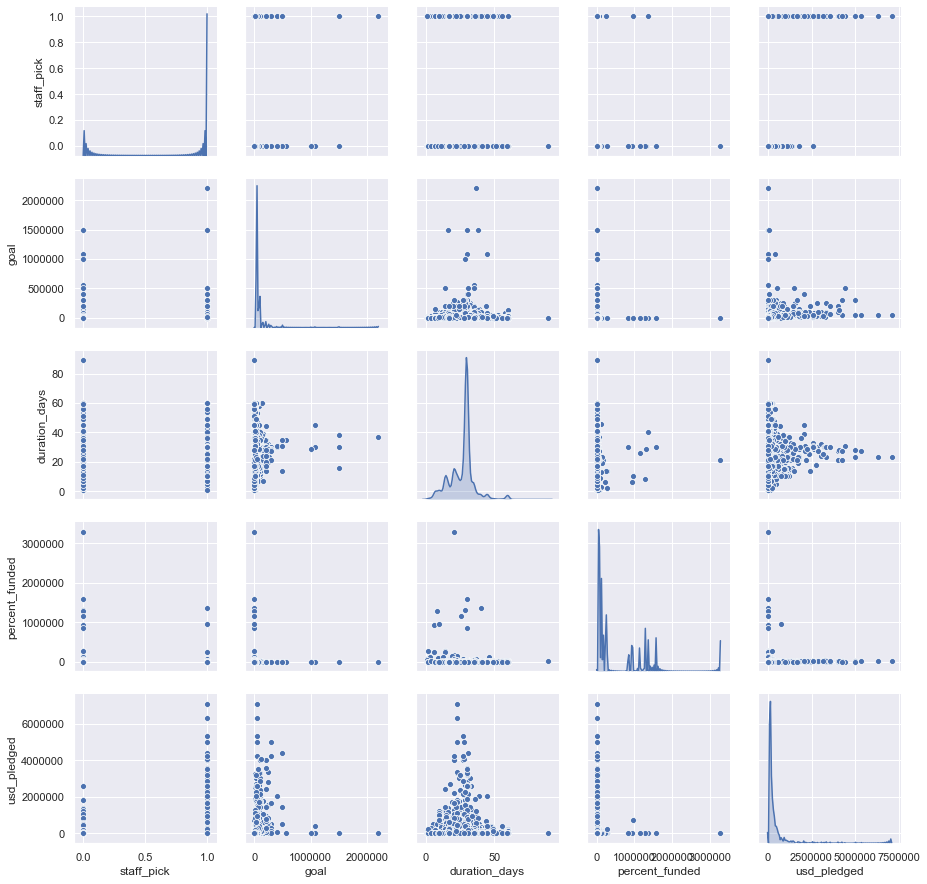

In [320]:
sns.pairplot(ks_df_2, diag_kind='kde')

In [168]:
# These are all successful, projects so pledged must always be >= goal,
#  unless i'm not properly accounting for currency
ks_df_2[ks_df_2['usd_pledged'] < ks_df_2['goal']]

staff_pick       goal  duration_days    usd_pledged
32              0    10000.0             30    9377.874146
48              0   100000.0             12    1707.616814
86              0    20000.0             35   18376.383253
110             0   100000.0             12    2858.378512
162             0     8000.0             30    7760.421893
240             0    20000.0             35   17313.623184
247             0      900.0             30     203.028828
310             0    22222.0             31    3985.120340
313             0     5000.0             30    3943.399192
346             0    15673.0             28    7144.632290
353             0    60000.0             30   11117.113355
435             0   200000.0             35   15037.466441
447             0   100000.0             23   89653.069892
449             0     7500.0             30    6261.755055
458             0     6000.0             21    5129.859676
472             1    50000.0             36   40146.183882
508             0     5000.0             30    4102.849654
512             0    10500.0             30   10064.262047
533             0    11000.0             30    8815.554247
555             0    90000.0             30   17012.656808
620             0    19000.0             30   18886.650723
635             0    27500.0             35    1841.931519
638             0    20000.0             34    6143.741970
640             1    30000.0             30   10971.831051
689             0    15000.0             28   13632.411908
767             0   150000.0             29   38294.302900
842             1   160000.0             30   24072.843904
904             0     3750.0             37    3045.689800
912             0     1400.0             28    1120.965452
923             1   256425.0             24   19498.126222
1039            0     3000.0             28    2550.802905
1064            0    20000.0             36    3023.103709
1107            0    10000.0             30    6957.277068
1138            0     2250.0             24    2096.840832
1153            0     6000.0             45    5728.175411
1246            0     7000.0             30    2627.506654
1255            0   105000.0             29   63115.445751
1298            0    60000.0             17   10966.600014
1308            0     2000.0             30     485.354830
1328            0    70000.0             37   12615.927156
1335            0    75000.0             30   50736.784364
1395            0     5000.0             25    3401.797944
1428            0    55000.0             30   12970.792455
1457            0    20000.0             40   16145.813456
1529            1   200000.0             30   66731.542299
1530            0   165000.0             30   22575.710301
1551            1   100000.0             12    1829.574438
1564            0     4500.0              9    3054.319172
1574            0     3000.0             30    2354.030694
1668            0    20000.0             30    3536.203032
1684            0    14000.0             36   11318.703450
1729            0    15000.0             19    4665.952323
1759            0   100000.0             30   38618.211458
1772            0     6000.0             30    4990.839622
1775            0     2500.0             45    2009.425023
1820            0    30000.0             40   29029.095925
1823            0    75000.0             30   22731.894902
1847            1   300000.0             30   38910.168966
1874            0   100000.0             20    3891.975706
1908            0     4000.0             31    3231.934211
1953            0    24000.0             20   18151.981004
2018            0    25000.0             31   14411.855722
2080            0     2500.0             19     633.575593
2098            0      200.0             30     192.801822
2408            1    85000.0             28   78895.072977
2438            0      996.0             21     878.405011
2453            0     9500.0             30    9464.74

In [504]:
ks_df_3 = df_2[[
    'launched_monday',
    'launched_tuesday',
    'launched_wednesday', 
    'launched_thursday', 
    'launched_friday', 
    'launched_saturday', 
    'launched_sunday',
    'deadline_monday',
    'deadline_tuesday',
    'deadline_wednesday', 
    'deadline_thursday', 
    'deadline_friday', 
    'deadline_saturday', 
    'deadline_sunday',
#   'backers_count',
    'profile_project_id',
    'pledged',
    'fx_rate',
    'country',
    'staff_pick',
    'goal',
    'duration_days', 
    'percent_funded',
    'usd_pledged'
   ]].dropna()
ks_df_3.sample(3)

launched_monday  launched_tuesday  launched_wednesday  \
353                 0                 0                   1   
9736                0                 0                   0   
5802                0                 0                   1   

      launched_thursday  launched_friday  launched_saturday  launched_sunday  \
353                   0                0                  0                0   
9736                  0                0                  1                0   
5802                  0                0                  0                0   

      deadline_monday  deadline_tuesday  deadline_wednesday  \
353                 0                 0                   0   
9736                1                 0                   0   
5802                0                 0                   1   

      deadline_thursday  deadline_friday  deadline_saturday  deadline_sunday  \
353                   0                1                  0                0   
9736                  0                0                  0                0   
5802                  0                0                  0                0   

      profile_project_id  pledged   fx_rate country  staff_pick     goal  \
353              3370309  87261.0  0.127493      HK           0  60000.0   
9736             3312807   1682.0  1.000000      US           0    750.0   
5802             3086767   2009.0  0.674564      AU           0   1000.0   

      duration_days  percent_funded   usd_pledged  
353              30      145.435000  11117.113355  
9736             30      224.266667   1682.000000  
5802             14      200.900000   1612.376369

In [206]:
ks_df_3[ks_df_3['usd_pledged'] < ks_df_3['goal']]

profile_project_id     pledged   fx_rate country  staff_pick  \
32                1014882    13055.52  0.674564      AU           0   
48                3662067   188959.00  0.009313      JP           0   
86                3281343    24175.29  0.752136      CA           0   
110               3280621   304700.00  0.009313      JP           0   
162               3325737    11124.72  0.674564      AU           0   
240               1373512    23073.00  0.752136      CA           0   
247               1931017     1729.00  0.100932      SE           0   
310               2164822    27210.66  0.146933      DK           0   
313               2287820     5414.50  0.674564      AU           0   
346               3494240    56060.00  0.127493      HK           0   
353               3370309    87261.00  0.127493      HK           0   
435               2805822   306815.00  0.051169      MX           0   
447               3322797   752252.00  0.100932      SE           0   
449               2711718     8240.00  0.674564      AU           0   
458               2740172     7155.00  0.631440      NZ           0   
472               3312057   319941.00  0.100932      SE           1   
508               3220582     5135.50  0.674564      AU           0   
512               3273725    12576.00  0.752136      CA           0   
533               2819330    11756.00  0.674564      AU           0   
555               3316324   133540.00  0.127493      HK           0   
620               3660271    26469.32  0.674564      AU           0   
635               3112325    33039.00  0.051169      MX           0   
638               3058003   108230.00  0.051169      MX           0   
640               2461839    91135.00  0.109570      NO           1   
689               2638802    17860.00  0.752136      CA           0   
767               3260028   306645.00  0.100932      SE           0   
842               3467384   188896.00  0.127493      HK           1   
904               2881067     4107.00  0.752136      CA           0   
912               3031534     1486.00  0.674564      AU           0   
923               3541105   372428.80  0.051169      MX           1   
1039              2445412     3560.00  0.674564      AU           0   
1064              3702969    20073.17  0.146933      DK           0   
1107              3682197    10075.32  0.674564      AU           0   
1138              3173452     2639.00  0.752136      CA           0   
1153              3394180     7666.00  0.724447      SG           0   
1246              2691219    23732.00  0.100932      SE           0   
1255              3320542   492900.00  0.109570      NO           0   
1298              3274986    86399.00  0.100932      SE           0   
1308              3241247     9470.00  0.051169      MX           0   
1328              1792640    96600.00  0.109570      NO           0   
1335              1870758   385711.24  0.109570      NO           0   
1395              3790721    66068.80  0.051169      MX           0   
1428              3495175   110683.00  0.109570      NO           0   
1457              2686908    21260.00  0.674564      AU           0   
1529              3545843   615744.71  0.100932      SE           1   
1530              3671498   192299.00  0.109570      NO           0   
1551              3789192   195009.00  0.009313      JP           1   
1564              3701802     4510.42  0.631440      NZ           0   
1574              3683610     3158.29  0.752136      CA           0   
1668              2716652    24805.00  0.146933      DK           0   
1684              1571618    14284.00  0.752136      CA           0   
1729              3295859    37166.00  0.100932      SE           0   
1759              3205961   300127.00  0.109570      NO           0   
1772              3402652     6761.32  0.674564      AU           0   
1775              3380759     2611.29  0.752136      CA           0   
1820              3064350   239

In [505]:
# this is not perfect, but it converts the goal into USD using the ration between USD_pledged and pledged (in local currency)

ks_df_3['usd_goal'] = ks_df_3['goal'] *  (ks_df_3['usd_pledged'] / ks_df_3['pledged'])


In [324]:

ks_df_3[ks_df_3['usd_pledged'] < ks_df_3['usd_goal']]

Empty DataFrame
Columns: [profile_project_id, pledged, fx_rate, country, staff_pick, goal, duration_days, percent_funded, usd_pledged, usd_goal]
Index: []

In [325]:
ks_df_3[(ks_df_3['country'] == 'US') & (ks_df_3['usd_goal'] != ks_df_3['goal'])]

Empty DataFrame
Columns: [profile_project_id, pledged, fx_rate, country, staff_pick, goal, duration_days, percent_funded, usd_pledged, usd_goal]
Index: []

### Now we can use usd_goal which scales properly to to usd_pledged, and gives us a consistent unit for pledged & goal amounts

In [326]:
ks_df_3.corr() # usd_goal correlates better to usd_pledged than goal

profile_project_id   pledged   fx_rate  staff_pick  \
profile_project_id            1.000000  0.007553 -0.022347   -0.169422   
pledged                       0.007553  1.000000 -0.164732    0.258192   
fx_rate                      -0.022347 -0.164732  1.000000   -0.027015   
staff_pick                   -0.169422  0.258192 -0.027015    1.000000   
goal                          0.004266  0.534061 -0.265702    0.143430   
duration_days                -0.187647  0.008421 -0.069806    0.057274   
percent_funded               -0.008591  0.009923 -0.004320    0.004751   
usd_pledged                  -0.010348  0.879754  0.012797    0.268999   
usd_goal                     -0.056022  0.487743  0.007541    0.267308   

                        goal  duration_days  percent_funded  usd_pledged  \
profile_project_id  0.004266      -0.187647       -0.008591    -0.010348   
pledged             0.534061       0.008421        0.009923     0.879754   
fx_rate            -0.265702      -0.069806       -0.004320     0.012797   
staff_pick          0.143430       0.057274        0.004751     0.268999   
goal                1.000000       0.046888       -0.010093     0.246713   
duration_days       0.046888       1.000000       -0.020732     0.001898   
percent_funded     -0.010093      -0.020732        1.000000     0.011362   
usd_pledged         0.246713       0.001898        0.011362     1.000000   
usd_goal            0.474729       0.063084       -0.017875     0.537396   

                    usd_goal  
profile_project_id -0.056022  
pledged             0.487743  
fx_rate             0.007541  
staff_pick          0.267308  
goal                0.474729  
duration_days       0.063084  
percent_funded     -0.017875  
usd_pledged         0.537396  
usd_goal            1.000000

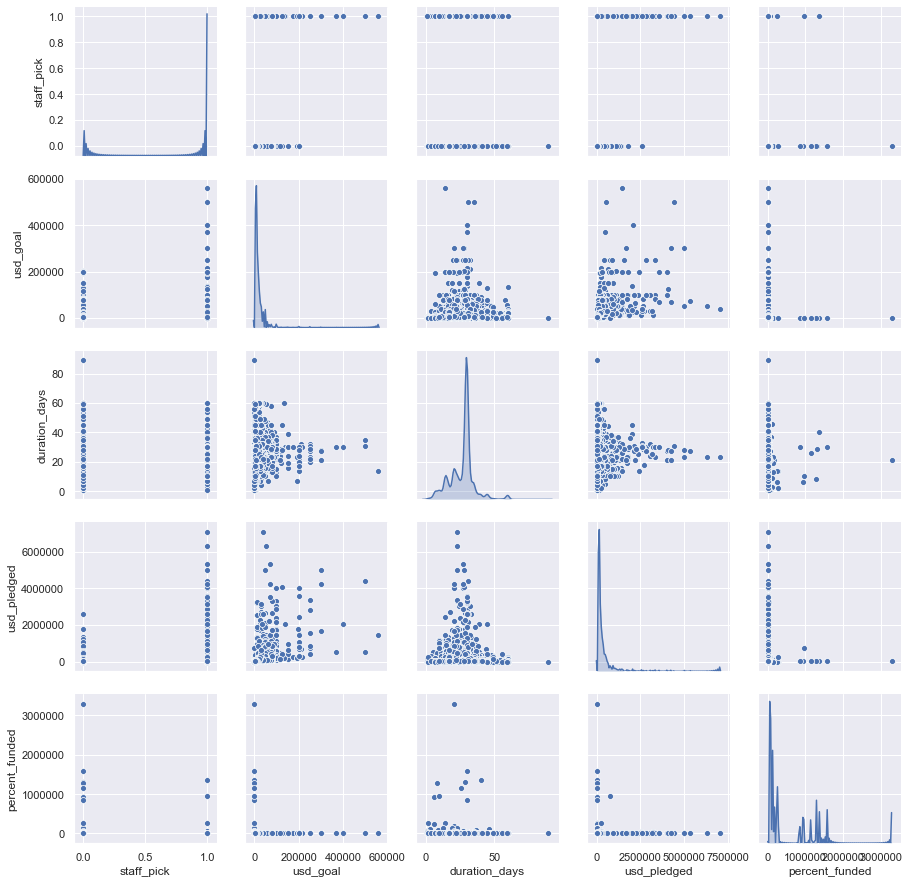

In [327]:
sns.pairplot(ks_df_3[['staff_pick','usd_goal','duration_days', 'usd_pledged', 'percent_funded']], diag_kind='kde')

### Model

In [506]:
X2 = ks_df_3[['usd_goal','duration_days', 'launched_monday',
    'launched_tuesday',
    'launched_wednesday', 
    'launched_thursday', 
    'launched_friday', 
    'launched_saturday', 
    'launched_sunday',
    'deadline_monday',
    'deadline_tuesday',
    'deadline_wednesday', 
    'deadline_thursday', 
    'deadline_friday', 
    'deadline_saturday', 
    'deadline_sunday',]]
y2 = ks_df_3['usd_pledged']
model(X2, y2)

Best possible Linear Regression R^2: 0.2624519371843087
K-Fold CV Linear Regression R^2: [0.19055182 0.0963661  0.32275928 0.35115795 0.36400981] mean:  0.2649689914093526
Linear Regression test R^2: 0.342
25263.73608919578
[('usd_goal', 5.8668449910165155),
 ('duration_days', -1000.3710605666914),
 ('launched_monday', -7939.41507077364),
 ('launched_tuesday', 13707.184410812479),
 ('launched_wednesday', -3895.5107155659807),
 ('launched_thursday', 2865.7867749874526),
 ('launched_friday', -7650.4749042811),
 ('launched_saturday', -8587.390459529004),
 ('launched_sunday', 11499.8199643498),
 ('deadline_monday', -3931.8446922336652),
 ('deadline_tuesday', -8299.281756580654),
 ('deadline_wednesday', 10212.990093205794),
 ('deadline_thursday', -3261.880621741599),
 ('deadline_friday', 7994.310349344035),
 ('deadline_saturday', -5357.988890622528),
 ('deadline_sunday', 2643.695518628627)]
Best possible Ridge Regression R^2: 0.262451932909452
K-fold CV Ridge Regression R^2:  [0.19055612 0.

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Polynomial Lasso Regression CV R^2:  0.11382889053016353
Polynomial Lasso Regression test R^2: 0.141
[('1', 0.0),
 ('x0', 0.0),
 ('x1', -0.0),
 ('x2', -0.0),
 ('x3', 0.0),
 ('x4', -0.0),
 ('x5', -0.0),
 ('x6', -0.0),
 ('x7', -0.0),
 ('x8', -0.0),
 ('x9', -0.0),
 ('x10', -0.0),
 ('x11', 0.0),
 ('x12', 0.0),
 ('x13', 0.0),
 ('x14', -0.0),
 ('x15', -0.0),
 ('x0^2', 1.2815064945409878e-05),
 ('x0 x1', 0.0),
 ('x0 x2', 0.0),
 ('x0 x3', 0.0),
 ('x0 x4', 0.0),
 ('x0 x5', 0.0),
 ('x0 x6', 0.0),
 ('x0 x7', 0.0),
 ('x0 x8', 0.0),
 ('x0 x9', 0.0),
 ('x0 x10', -0.0),
 ('x0 x11', 0.0),
 ('x0 x12', 0.0),
 ('x0 x13', 0.0),
 ('x0 x14', 0.0),
 ('x0 x15', 0.0),
 ('x1^2', -0.0),
 ('x1 x2', -0.0),
 ('x1 x3', 0.0),
 ('x1 x4', -0.0),
 ('x1 x5', -0.0),
 ('x1 x6', -0.0),
 ('x1 x7', -0.0),
 ('x1 x8', -0.0),
 ('x1 x9', -0.0),
 ('x1 x10', -0.0),
 ('x1 x11', 0.0),
 ('x1 x12', 0.0),
 ('x1 x13', 0.0),
 ('x1 x14', -0.0),
 ('x1 x15', -0.0),
 ('x2^2', -0.0),
 ('x2 x3', 0.0),
 ('x2 x4', 0.0),
 ('x2 x5', 0.0),
 ('x2 x6'

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
         max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
         positive=False, precompute='auto', random_state=None,
         selection='cyclic', tol=0.0001, verbose=False))

In [329]:
X2 = ks_df_3[['staff_pick','usd_goal','duration_days']]
y2 = ks_df_3['percent_funded']
model(X2, y2)

Best possible Linear Regression R^2: 0.0009139032161450399
K-Fold CV Linear Regression R^2: [-1.63878846e-03 -2.77207638e-01  2.21611595e-04 -6.37092131e-03
  1.35591480e-03] mean:  -0.05672796423049644
Linear Regression test R^2: -0.154
6428.265289513753
[('staff_pick', 1768.7304413570441),
 ('usd_goal', -0.050313736787244025),
 ('duration_days', -130.05055211919108)]
Best possible Ridge Regression R^2: 0.000913903197218846
K-fold CV Ridge Regression R^2:  [-1.63843309e-03 -2.77133202e-01  2.21503860e-04 -6.36936816e-03
  1.35583088e-03] mean:  -0.05671273375534871
Ridge Regression test R^2: -0.154
2695.011686915628
[('staff_pick', 637.4987310754145),
 ('usd_goal', -1098.7485165948851),
 ('duration_days', -1142.4796518597216)]
Best possible Polynomial Regression R^2: 0.0015198657805267635
K-fold CV Polynomial Regression R^2:  -0.07108115296213939 mean:  -0.07108115296213939
Polynomial Regression test R^2: -0.193
10299.805638753654
[('1', 0.0),
 ('x0', 1309.1474684549166),
 ('x1', -0.1

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
         max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
         positive=False, precompute='auto', random_state=None,
         selection='cyclic', tol=0.0001, verbose=False))

In [507]:
m = sm.OLS(y2,X2)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     309.6
Date:                Fri, 11 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:18:06   Log-Likelihood:            -1.4467e+05
No. Observations:               10561   AIC:                         2.894e+05
Df Residuals:                   10546   BIC:                         2.895e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
usd_goal               6.5411      0.101     64.867      0.000       6.343       6.739
duration_days       -920.4414    238.821     -3.854      0.000   -1388.576    -452.306
launched_monday     5552.1457   6067.299      0.915      0.360   -6340.907    1.74e+04
launched_tuesday    2.178e+04   5170.218      4.213      0.000    1.16e+04    3.19e+04
launched_wednesday  5719.4434   6151.186      0.930      0.352   -6338.044    1.78e+04
launched_thursday   5424.3833   6552.146      0.828      0.408   -7419.061    1.83e+04
launched_friday     4210.0964   6642.801      0.634      0.526   -8811.049    1.72e+04
launched_saturday   3206.8858   8517.381      0.377      0.707   -1.35e+04    1.99e+04
launched_sunday      2.21e+04   9969.739      2.216      0.027    2554.564    4.16e+04
deadline_monday     4285.7285   6531.399      0.656      0.512   -8517.048    1.71e+04
deadline_tuesday    4148.0357   6585.297      0.630      0.529   -8760.390    1.71e+04
deadline_wednesday  2.057e+04   6348.670      3.241      0.001    8130.254     3.3e+04
deadline_thursday   4036.1092   6184.030      0.653      0.514   -8085.758    1.62e+04
deadline_friday     1.777e+04   6001.554      2.960      0.003    6003.065    2.95e+04
deadline_saturday   3951.4205   6657.414      0.594      0.553   -9098.369     1.7e+04
deadline_sunday     1.323e+04   6775.237      1.953      0.051     -49.584    2.65e+04
==============================================================================
Omnibus:                    18687.269   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32601280.669
Skew:                          12.518   Prob(JB):                         0.00
Kurtosis:                     274.035   Cond. No.                     2.42e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# add Kickstarter page data

In [331]:
ks_pg_df = pd.read_pickle('/Users/kirill.kogan/Documents/data/metis_p02_kickstarter/pickles/ks_pgs.pkl')

In [332]:
ks_pg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10627 entries, 0 to 10626
Data columns (total 9 columns):
image_count               10627 non-null int64
mentions_stretch_goals    10627 non-null int64
profile_project_id        10627 non-null int64
reward_average            10627 non-null float64
reward_count              10627 non-null int64
reward_max                10627 non-null float64
reward_median             10627 non-null float64
reward_std                10627 non-null float64
video_count               10627 non-null int64
dtypes: float64(4), int64(5)
memory usage: 747.3 KB


In [333]:
ks_pg_df.drop_duplicates(inplace=True, subset='profile_project_id')

In [334]:
ks_pg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10562 entries, 0 to 10626
Data columns (total 9 columns):
image_count               10562 non-null int64
mentions_stretch_goals    10562 non-null int64
profile_project_id        10562 non-null int64
reward_average            10562 non-null float64
reward_count              10562 non-null int64
reward_max                10562 non-null float64
reward_median             10562 non-null float64
reward_std                10562 non-null float64
video_count               10562 non-null int64
dtypes: float64(4), int64(5)
memory usage: 825.2 KB


In [335]:
ks_df_3.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10561 entries, 0 to 11606
Data columns (total 10 columns):
profile_project_id    10561 non-null int64
pledged               10561 non-null float64
fx_rate               10561 non-null float64
country               10561 non-null object
staff_pick            10561 non-null int64
goal                  10561 non-null float64
duration_days         10561 non-null int64
percent_funded        10561 non-null float64
usd_pledged           10561 non-null float64
usd_goal              10561 non-null float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.2+ MB


In [336]:
ks_df_4 = ks_pg_df.merge(ks_df_3, how='left', left_on='profile_project_id', right_on='profile_project_id')

In [338]:
ks_df_4.dropna(inplace=True)
ks_df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10560 entries, 0 to 10561
Data columns (total 18 columns):
image_count               10560 non-null int64
mentions_stretch_goals    10560 non-null int64
profile_project_id        10560 non-null int64
reward_average            10560 non-null float64
reward_count              10560 non-null int64
reward_max                10560 non-null float64
reward_median             10560 non-null float64
reward_std                10560 non-null float64
video_count               10560 non-null int64
pledged                   10560 non-null float64
fx_rate                   10560 non-null float64
country                   10560 non-null object
staff_pick                10560 non-null float64
goal                      10560 non-null float64
duration_days             10560 non-null float64
percent_funded            10560 non-null float64
usd_pledged               10560 non-null float64
usd_goal                  10560 non-null float64
dtypes: float64(12),

In [339]:
ks_df_4.describe()

image_count  mentions_stretch_goals  profile_project_id  \
count  10560.000000            10560.000000        1.056000e+04   
mean      23.799905                0.717803        2.701054e+06   
std       19.711183                0.450090        9.339731e+05   
min        0.000000                0.000000        1.484000e+03   
25%       10.000000                0.000000        2.216909e+06   
50%       19.000000                1.000000        2.976127e+06   
75%       32.000000                1.000000        3.424030e+06   
max      176.000000                1.000000        3.819693e+06   

       reward_average  reward_count    reward_max  reward_median  \
count    10560.000000  10560.000000  10560.000000   10560.000000   
mean       111.199864      9.312121    550.201894      52.942188   
std        184.240839      5.874926   1274.425938      76.725026   
min          1.000000      2.000000      1.000000       1.000000   
25%         31.142857      6.000000     80.000000      21.000000   
50%         60.857143      8.000000    184.000000      37.500000   
75%        115.308036     11.000000    480.000000      64.000000   
max       4946.200000    117.000000  24588.000000    2700.000000   

         reward_std   video_count       pledged       fx_rate    staff_pick  \
count  10560.000000  10560.000000  1.056000e+04  10560.000000  10560.000000   
mean     160.524748      0.986080  7.234589e+04      1.002524      0.152178   
std      360.330077      1.077671  2.800698e+05      0.174924      0.359210   
min        0.000000      0.000000  8.000000e+00      0.009313      0.000000   
25%       27.396110      1.000000  4.002405e+03      1.000000      0.000000   
50%       58.059340      1.000000  1.242448e+04      1.000000      0.000000   
75%      138.225018      1.000000  3.950240e+04      1.000000      0.000000   
max     9820.917847     43.000000  7.072757e+06      1.229370      1.000000   

               goal  duration_days  percent_funded   usd_pledged  \
count  1.056000e+04   10560.000000    1.056000e+04  1.056000e+04   
mean   1.242611e+04      26.791383    2.266374e+03  6.549389e+04   
std    4.468875e+04       8.814390    4.640652e+04  2.556339e+05   
min    1.000000e+00       1.000000    1.000000e+02  8.000000e+00   
25%    1.000000e+03      21.000000    1.516000e+02  4.009598e+03   
50%    5.000000e+03      30.000000    2.984000e+02  1.242260e+04   
75%    1.235875e+04      30.000000    6.936600e+02  3.790501e+04   
max    2.200000e+06      89.000000    3.284300e+06  7.072757e+06   

            usd_goal  
count   10560.000000  
mean    10571.300526  
std     20991.070392  
min         0.735634  
25%      1000.000000  
50%      4992.825836  
75%     12000.000000  
max    559274.735000

In [340]:
#ks_df_4.drop(['goal', 'fx_rate', 'pledged'], axis=1, inplace=True)
ks_df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10560 entries, 0 to 10561
Data columns (total 18 columns):
image_count               10560 non-null int64
mentions_stretch_goals    10560 non-null int64
profile_project_id        10560 non-null int64
reward_average            10560 non-null float64
reward_count              10560 non-null int64
reward_max                10560 non-null float64
reward_median             10560 non-null float64
reward_std                10560 non-null float64
video_count               10560 non-null int64
pledged                   10560 non-null float64
fx_rate                   10560 non-null float64
country                   10560 non-null object
staff_pick                10560 non-null float64
goal                      10560 non-null float64
duration_days             10560 non-null float64
percent_funded            10560 non-null float64
usd_pledged               10560 non-null float64
usd_goal                  10560 non-null float64
dtypes: float64(12),

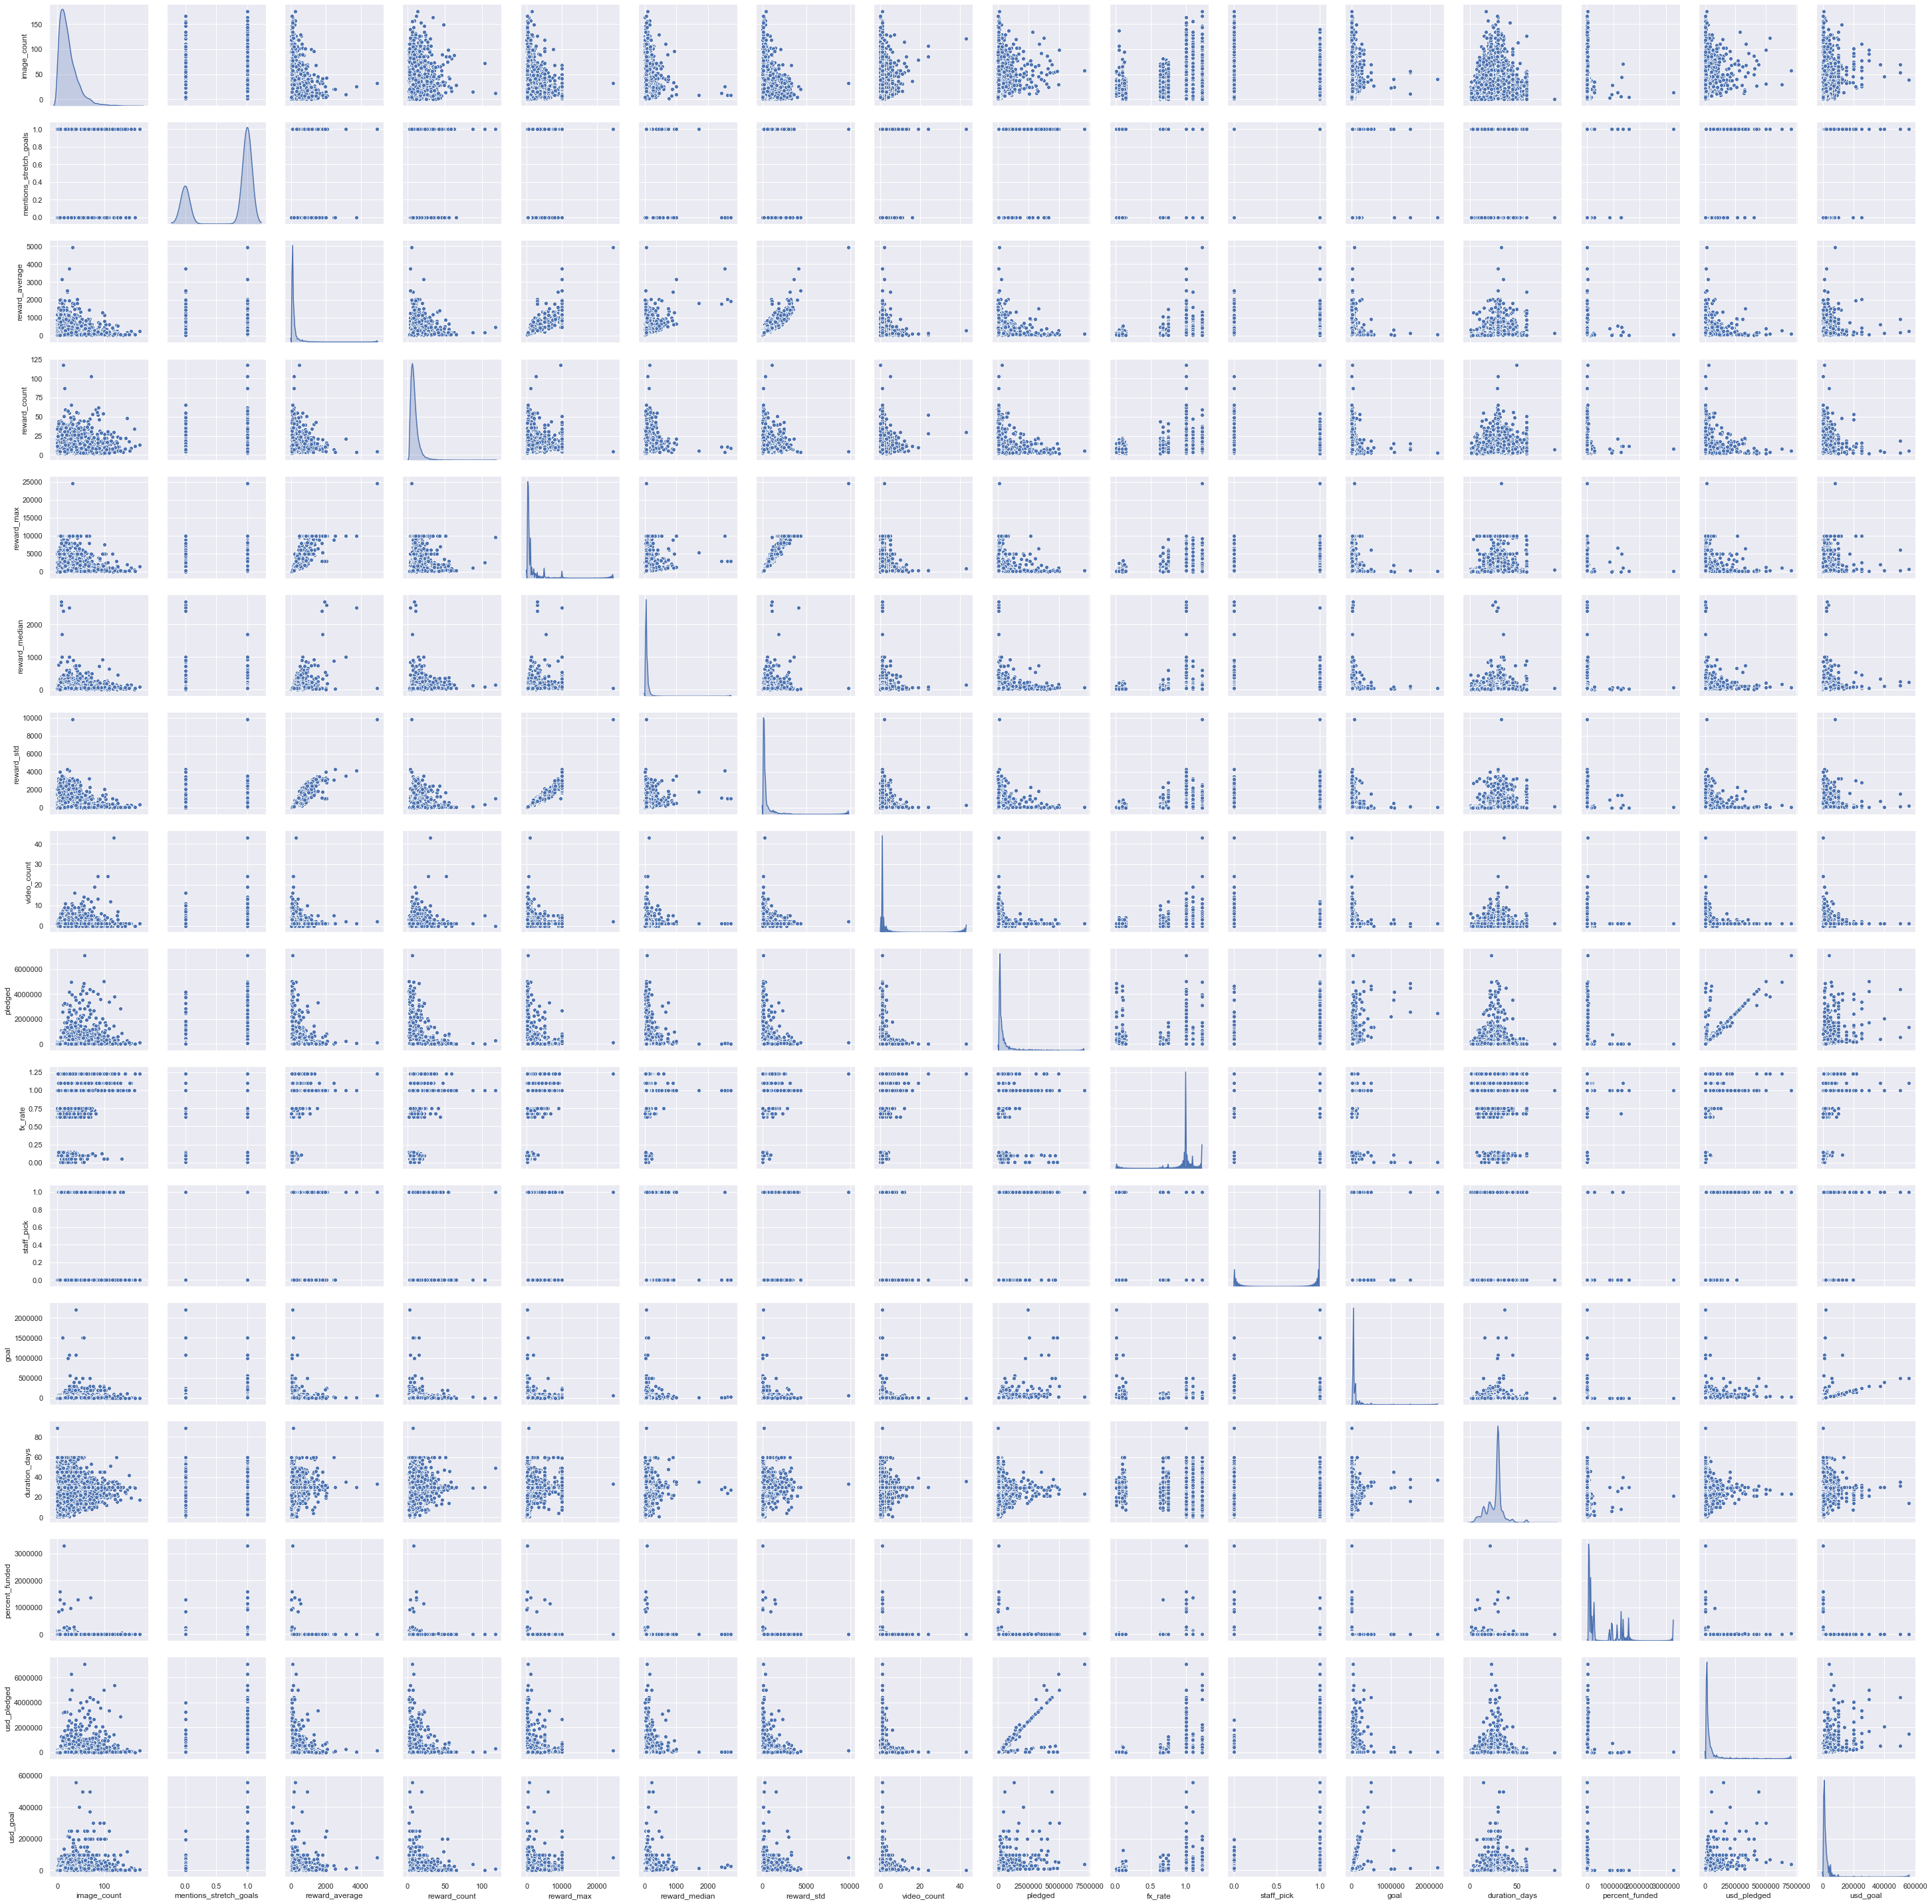

In [341]:
sns.pairplot(ks_df_4.drop(['profile_project_id','country'], axis=1), diag_kind='kde')

In [342]:
ks_df_4.drop(['profile_project_id','country'], axis=1).corr()

image_count  mentions_stretch_goals  reward_average  \
image_count                1.000000                0.213261        0.105614   
mentions_stretch_goals     0.213261                1.000000        0.025458   
reward_average             0.105614                0.025458        1.000000   
reward_count               0.145029                0.065440        0.262771   
reward_max                 0.055296                0.022234        0.893796   
reward_median              0.182720                0.042813        0.557679   
reward_std                 0.052631                0.016529        0.940383   
video_count                0.197371                0.036222        0.104982   
pledged                    0.248405                0.078429        0.106015   
fx_rate                    0.024811                0.006828        0.011144   
staff_pick                 0.111467                0.081124        0.120240   
goal                       0.162409                0.056268        0.102106   
duration_days              0.025814                0.025813        0.153107   
percent_funded            -0.000847               -0.001908        0.006712   
usd_pledged                0.257115                0.088972        0.121835   
usd_goal                   0.304615                0.135025        0.230659   

                        reward_count  reward_max  reward_median  reward_std  \
image_count                 0.145029    0.055296       0.182720    0.052631   
mentions_stretch_goals      0.065440    0.022234       0.042813    0.016529   
reward_average              0.262771    0.893796       0.557679    0.940383   
reward_count                1.000000    0.311743       0.258598    0.233794   
reward_max                  0.311743    1.000000       0.303162    0.977560   
reward_median               0.258598    0.303162       1.000000    0.315527   
reward_std                  0.233794    0.977560       0.315527    1.000000   
video_count                 0.102763    0.084609       0.094440    0.086845   
pledged                     0.020443    0.065228       0.154754    0.063956   
fx_rate                     0.018610    0.005260       0.018534    0.005234   
staff_pick                  0.044178    0.098712       0.098211    0.101985   
goal                        0.024366    0.072707       0.116964    0.072825   
duration_days               0.216629    0.162584       0.080629    0.149334   
percent_funded              0.000556    0.016806      -0.002314    0.013799   
usd_pledged                 0.025257    0.077172       0.174025    0.075584   
usd_goal                    0.066955    0.171452       0.249522    0.171356   

                        video_count   pledged   fx_rate  staff_pick      goal  \
image_count                0.197371  0.248405  0.024811    0.111467  0.162409   
mentions_stretch_goals     0.036222  0.078429  0.006828    0.081124  0.056268   
reward_average             0.104982  0.106015  0.011144    0.120240  0.102106   
reward_count               0.102763  0.020443  0.018610    0.044178  0.024366   
reward_max                 0.084609  0.065228  0.005260    0.098712  0.072707   
reward_median              0.094440  0.154754  0.018534    0.098211  0.116964   
reward_std                 0.086845  0.063956  0.005234    0.101985  0.072825   
video_count                1.000000  0.044876 -0.029414    0.057828  0.049113   
pledged                    0.044876  1.000000 -0.164738    0.258047  0.534047   
fx_rate                   -0.029414 -0.164738  1.000000   -0.027019 -0.265704   
staff_pick                 0.057828  0.258047 -0.027019    1.000000  0.143361   
goal                       0.049113  0.534047 -0.265704    0.143361  1.000000   
duration_days              0.111160  0.008485 -0.069808    0.057437  0.046919   
percent_funded            -0.001396  0.009926 -0.004320    0.004758 -0.010092   
usd_pledged                0.047216  0.879742  0.012799    0.268832  0.246679   
usd_goal                   0.097388  0.4

In [225]:
ks_df_4.drop(['profile_project_id','country'], axis=1).head()

image_count  mentions_stretch_goals  reward_average  reward_count  \
0           11                       0       16.500000             2   
1           12                       0       33.625000             8   
2            9                       0       37.777778             9   
3           47                       1       51.250000             4   
4           25                       1       43.500000             4   

   reward_max  reward_median  reward_std  video_count  staff_pick  \
0        32.0           16.5   15.500000            1         0.0   
1        75.0           32.0   24.335866            3         0.0   
2       130.0           20.0   40.046578            0         0.0   
3        74.0           65.0   29.456536            1         1.0   
4        83.0           44.5   28.917987            0         0.0   

   duration_days   usd_pledged     usd_goal  
0           22.0  36959.000000  20000.00000  
1           30.0   4246.000000   3000.00000  
2           31.0  11614.000000    600.00000  
3           18.0  47273.500000  35000.00000  
4           17.0   6502.807488   2118.86852

In [343]:
ks_df_4_na = ks_df_4.dropna()

In [ ]:
# NO USD GOAL

In [351]:
ks_df_4_na.drop(['profile_project_id','country', 'usd_pledged', 'pledged', 'fx_rate', 'percent_funded', 'staff_pick', 'goal'], axis=1).info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10560 entries, 0 to 10561
Data columns (total 11 columns):
image_count               10560 non-null int64
mentions_stretch_goals    10560 non-null int64
reward_average            10560 non-null float64
reward_count              10560 non-null int64
reward_max                10560 non-null float64
reward_median             10560 non-null float64
reward_std                10560 non-null float64
video_count               10560 non-null int64
goal                      10560 non-null float64
duration_days             10560 non-null float64
usd_goal                  10560 non-null float64
dtypes: float64(7), int64(4)
memory usage: 990.0 KB


In [355]:
X3 = ks_df_4_na.drop(['profile_project_id','country', 'usd_pledged', 'pledged', 'fx_rate', 'percent_funded', 'staff_pick', 'goal'], axis=1)
y3 = ks_df_4_na['usd_pledged']
model(X3, y3)

Best possible Linear Regression R^2: 0.33449074227140463
K-Fold CV Linear Regression R^2: [0.41740029 0.34135687 0.5099039  0.16240904 0.2186312 ] mean:  0.3299402594222347
Linear Regression test R^2: 0.140
1993.0562851607756
[('image_count', 1286.4730174373644),
 ('mentions_stretch_goals', -3081.4388469389287),
 ('reward_average', -60.81759180700185),
 ('reward_count', -1421.6379024092773),
 ('reward_max', 17.574977755590016),
 ('reward_median', 84.95505552218589),
 ('reward_std', -51.808789713873146),
 ('video_count', -5380.4967609353425),
 ('duration_days', -781.5865647426743),
 ('usd_goal', 7.215952671266546)]
Best possible Ridge Regression R^2: 0.33449072029170746
K-fold CV Ridge Regression R^2:  [0.41739204 0.34134336 0.50992349 0.16245672 0.21865715] mean:  0.3299545546284848
Ridge Regression test R^2: 0.140
64894.92482094279
[('image_count', 25332.95732409018),
 ('mentions_stretch_goals', -1390.8769514293951),
 ('reward_average', -11194.783009219074),
 ('reward_count', -8466.09

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
         max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
         positive=False, precompute='auto', random_state=None,
         selection='cyclic', tol=0.0001, verbose=False))

In [356]:
m = sm.OLS(y3,X3)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.345
Model:                            OLS   Adj. R-squared (uncentered):              0.345
Method:                 Least Squares   F-statistic:                              556.5
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                        10:20:48   Log-Likelihood:                     -1.4457e+05
No. Observations:               10560   AIC:                                  2.892e+05
Df Residuals:                   10550   BIC:                                  2.892e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
image_count             1364.5629    114.235     11.945      0.000    1140.641    1588.485
mentions_stretch_goals   287.0870   4465.928      0.064      0.949   -8466.975    9041.149
reward_average           111.8403     70.833      1.579      0.114     -27.006     250.687
reward_count           -1546.9747    416.734     -3.712      0.000   -2363.851    -730.098
reward_max                29.2629     10.536      2.777      0.005       8.610      49.916
reward_median             86.9813     55.234      1.575      0.115     -21.288     195.251
reward_std              -162.0395     60.054     -2.698      0.007    -279.757     -44.322
video_count            -4492.1399   1980.207     -2.269      0.023   -8373.719    -610.561
duration_days           -745.0792    170.367     -4.373      0.000   -1079.030    -411.128
usd_goal                   6.0920      0.108     56.382      0.000       5.880       6.304
==============================================================================
Omnibus:                    18759.765   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32932342.383
Skew:                          12.629   Prob(JB):                         0.00
Kurtosis:                     275.412   Cond. No.                     5.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [358]:
X3 = ks_df_4_na.drop(['profile_project_id','country', 'usd_pledged', 'pledged', 'fx_rate', 'percent_funded', 'staff_pick', 'goal', 'usd_goal'], axis=1)
y3 = ks_df_4_na['usd_pledged']
model(X3, y3)

Best possible Linear Regression R^2: 0.09539060618778805
K-Fold CV Linear Regression R^2: [0.1169191  0.1070936  0.07397641 0.02698695 0.08938088] mean:  0.08287138598132704
Linear Regression test R^2: 0.071
-8435.980745060588
[('image_count', 3092.9773130256),
 ('mentions_stretch_goals', 26526.852018356814),
 ('reward_average', 541.0931996523913),
 ('reward_count', -4542.220516205985),
 ('reward_max', 82.44198510642079),
 ('reward_median', 161.69099939945235),
 ('reward_std', -495.2752099492663),
 ('video_count', -2908.246154160815),
 ('duration_days', -265.6445105383238)]
Best possible Ridge Regression R^2: 0.09538872708571389
K-fold CV Ridge Regression R^2:  [0.11701059 0.10696875 0.07396644 0.02728568 0.08938326] mean:  0.08292294409575666
Ridge Regression test R^2: 0.071
67311.69507122494
[('image_count', 61619.62349047174),
 ('mentions_stretch_goals', 11883.768342244732),
 ('reward_average', 97763.33208218326),
 ('reward_count', -25644.541904463164),
 ('reward_max', 101100.604503

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1272158386695.0, tolerance: 41572055355.366135
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2894023268197.75, tolerance: 41572055355.366135
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

Polynomial Lasso Regression CV R^2:  0.06821189079130607
Polynomial Lasso Regression test R^2: 0.077
[('1', 0.0),
 ('x0', 0.0),
 ('x1', 0.0),
 ('x2', 0.0),
 ('x3', -0.0),
 ('x4', 0.0),
 ('x5', 0.0),
 ('x6', 0.0),
 ('x7', 0.0),
 ('x8', -0.0),
 ('x0^2', 0.0),
 ('x0 x1', 0.0),
 ('x0 x2', 0.6756849226670621),
 ('x0 x3', 0.0),
 ('x0 x4', 0.6069446733734025),
 ('x0 x5', 8.359452776946135),
 ('x0 x6', 0.0),
 ('x0 x7', 0.0),
 ('x0 x8', 0.0),
 ('x1^2', 0.0),
 ('x1 x2', 0.0),
 ('x1 x3', 0.0),
 ('x1 x4', 0.0),
 ('x1 x5', 0.0),
 ('x1 x6', 0.0),
 ('x1 x7', 0.0),
 ('x1 x8', 0.0),
 ('x2^2', -0.0),
 ('x2 x3', 0.0),
 ('x2 x4', 0.009854374875956496),
 ('x2 x5', -0.0),
 ('x2 x6', -0.0),
 ('x2 x7', -0.0),
 ('x2 x8', 0.0),
 ('x3^2', -0.0),
 ('x3 x4', 0.0),
 ('x3 x5', 0.0),
 ('x3 x6', 0.0),
 ('x3 x7', -0.0),
 ('x3 x8', -0.0),
 ('x4^2', -0.005037011761304364),
 ('x4 x5', 0.2662857003813923),
 ('x4 x6', 0.005375352747918171),
 ('x4 x7', -0.0),
 ('x4 x8', -0.0),
 ('x5^2', -0.0839278056926283),
 ('x5 x6', -0.63

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57290254277471.0, tolerance: 57237326472.08073
  positive)


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
         max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
         positive=False, precompute='auto', random_state=None,
         selection='cyclic', tol=0.0001, verbose=False))

In [359]:
m = sm.OLS(y3,X3)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.148
Model:                            OLS   Adj. R-squared (uncentered):              0.147
Method:                 Least Squares   F-statistic:                              203.7
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                        10:23:27   Log-Likelihood:                     -1.4596e+05
No. Observations:               10560   AIC:                                  2.919e+05
Df Residuals:                   10551   BIC:                                  2.920e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
image_count             2972.9308    126.180     23.561      0.000    2725.594    3220.267
mentions_stretch_goals  1.952e+04   5079.413      3.843      0.000    9563.112    2.95e+04
reward_average           524.0355     80.368      6.520      0.000     366.499     681.572
reward_count           -3840.0200    473.100     -8.117      0.000   -4767.385   -2912.655
reward_max                88.7089     11.958      7.418      0.000      65.268     112.150
reward_median            114.5697     63.003      1.818      0.069      -8.929     238.068
reward_std              -505.3858     68.151     -7.416      0.000    -638.975    -371.797
video_count            -2030.9782   2258.278     -0.899      0.368   -6457.629    2395.673
duration_days           -486.5446    194.267     -2.505      0.012    -867.345    -105.744
==============================================================================
Omnibus:                    18428.623   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21522672.306
Skew:                          12.342   Prob(JB):                         0.00
Kurtosis:                     222.786   Cond. No.                     3.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model

In [297]:
X3_2 = ks_df_4_na.drop(['profile_project_id','country', 'usd_pledged', 'mentions_stretch_goals'], axis=1)
y3_2 = ks_df_4_na['usd_pledged']
model(X3_2, y3_2)

Best possible Linear Regression R^2: 0.32862738600549424
K-Fold CV Linear Regression R^2: [0.43338155 0.43278263 0.26672843 0.11948605 0.35822148] mean:  0.3221200267191193
Linear Regression test R^2: 0.293
-4311.78436197462
[('image_count', 1323.3540005387597),
 ('reward_average', 65.89709171226737),
 ('reward_count', -1431.8686956344563),
 ('reward_max', 32.1981464540317),
 ('reward_median', 145.92494579542844),
 ('reward_std', -159.63720817310244),
 ('video_count', -3901.9687231404114),
 ('staff_pick', 99564.8325943996),
 ('duration_days', -911.7128343699835),
 ('usd_goal', 5.423532803568526)]
Best possible Ridge Regression R^2: 0.32862720216519714
K-fold CV Ridge Regression R^2:  [0.4333815  0.43282548 0.26671492 0.11980598 0.35822036] mean:  0.32218964661597305
Ridge Regression test R^2: 0.293
65417.50458249509
[('image_count', 25779.41492876189),
 ('reward_average', 10808.553592041779),
 ('reward_count', -8351.070863480409),
 ('reward_max', 39363.221432260725),
 ('reward_median',

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
         max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
         positive=False, precompute='auto', random_state=None,
         selection='cyclic', tol=0.0001, verbose=False))

In [272]:
m = sm.OLS(y3_2,X3_2)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.361
Model:                            OLS   Adj. R-squared (uncentered):              0.360
Method:                 Least Squares   F-statistic:                              596.1
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                        09:36:47   Log-Likelihood:                     -1.4444e+05
No. Observations:               10560   AIC:                                  2.889e+05
Df Residuals:                   10550   BIC:                                  2.890e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
image_count     1304.0587    109.342     11.926      0.000    1089.728    1518.390
reward_average   115.0610     69.894      1.646      0.100     -21.944     252.066
reward_count   -1651.0007    408.123     -4.045      0.000   -2450.998    -851.003
reward_max        32.2329     10.383      3.104      0.002      11.880      52.585
reward_median     79.7479     54.535      1.462      0.144     -27.151     186.646
reward_std      -177.9378     59.212     -3.005      0.003    -294.004     -61.871
video_count    -5200.5347   1956.459     -2.658      0.008   -9035.564   -1365.505
staff_pick      9.581e+04   5948.880     16.106      0.000    8.42e+04    1.07e+05
duration_days   -961.5408    155.736     -6.174      0.000   -1266.812    -656.269
usd_goal           5.6922      0.109     52.080      0.000       5.478       5.906
==============================================================================
Omnibus:                    18719.714   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32723725.764
Skew:                          12.570   Prob(JB):                         0.00
Kurtosis:                     274.551   Cond. No.                     6.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# PRESENTATION MODEL

In [477]:
X3_3 = ks_df_4_na.drop(['profile_project_id','country', 'usd_pledged', 'goal', 'staff_pick', 'pledged', 'mentions_stretch_goals', 'fx_rate', 'percent_funded', 'reward_median', 'reward_average'], axis=1)
y3_3 = ks_df_4_na['usd_pledged']
l3, r3, p2, la = model(X3_3, y3_3)

Best possible Linear Regression R^2: 0.28582150403816975
K-Fold CV Linear Regression R^2: [0.31346894 0.264805   0.39738439 0.20228594 0.22022466] mean:  0.27963378804962136
Linear Regression test R^2: 0.345
2213.5312474131497
[('image_count', 1416.8142510237456),
 ('reward_count', -786.3725399316668),
 ('reward_max', 6.358061539588783),
 ('reward_std', -26.7351750236473),
 ('video_count', -4160.683029815909),
 ('duration_days', -796.0158160805389),
 ('usd_goal', 6.061583259935231)]
Best possible Ridge Regression R^2: 0.28582149785413213
K-fold CV Ridge Regression R^2:  [0.31345618 0.26480971 0.39735671 0.20230873 0.22026021] mean:  0.27963830906759357
Ridge Regression test R^2: 0.345
65852.45136787652
[('image_count', 27587.773472363337),
 ('reward_count', -4637.721658100544),
 ('reward_max', 8045.891220445913),
 ('reward_std', -9675.601808549476),
 ('video_count', -4092.996915203073),
 ('duration_days', -7062.074362561774),
 ('usd_goal', 127833.8928378863)]
Best possible Polynomial R

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [478]:
m = sm.OLS(y3_3,X3_3)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.343
Model:                            OLS   Adj. R-squared (uncentered):              0.343
Method:                 Least Squares   F-statistic:                              788.5
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                        0.00
Time:                        12:45:02   Log-Likelihood:                     -1.4459e+05
No. Observations:               10560   AIC:                                  2.892e+05
Df Residuals:                   10553   BIC:                                  2.892e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
image_count    1418.7859    110.264     12.867      0.000    1202.647    1634.925
reward_count   -914.4877    393.038     -2.327      0.020   -1684.916    -144.060
reward_max       13.6944      8.355      1.639      0.101      -2.683      30.072
reward_std      -52.3723     28.985     -1.807      0.071    -109.189       4.445
video_count   -4317.9121   1981.701     -2.179      0.029   -8202.420    -433.405
duration_days  -757.7985    156.771     -4.834      0.000   -1065.100    -450.497
usd_goal          6.2092      0.106     58.758      0.000       6.002       6.416
==============================================================================
Omnibus:                    18761.324   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32942388.834
Skew:                          12.631   Prob(JB):                         0.00
Kurtosis:                     275.453   Cond. No.                     2.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 2160x1440 with 0 Axes>

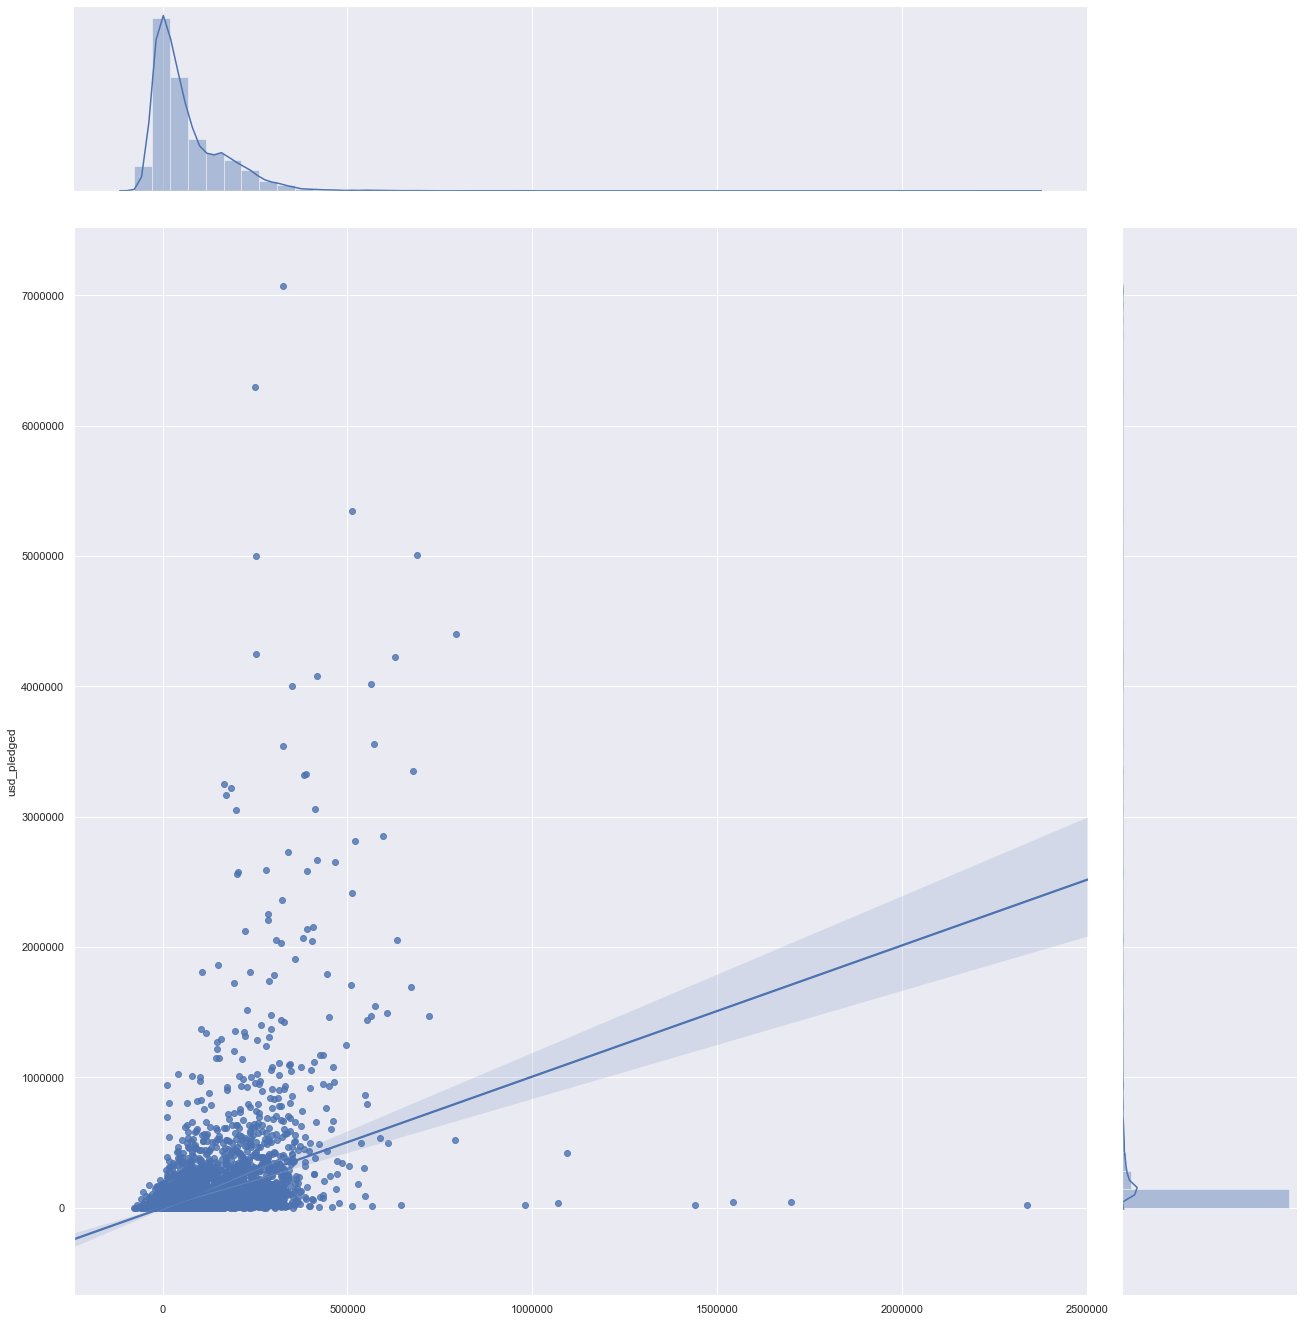

In [490]:
plt.figure(figsize=(30,20))
preds3 = fit.predict(X3_3) # generate predictions (on training data) using fit model

grid = sns.jointplot(preds, y3_3, kind='regplot')
#ax = sns.regplot(preds3, y3_3)
grid.fig.set_figwidth(20)
grid.fig.set_figheight(20)
#ax.set_xlabel("USD Pledged Predicted",fontsize=30)
#ax.set_ylabel("USD Pledged Actual",fontsize=30)
#ax.tick_params(labelsize=20)

In [480]:
print(preds3)

[2.52037674e+09 3.79250786e+08 7.76806047e+07 ... 1.79316248e+09
 2.54355358e+09 2.02175309e+09]


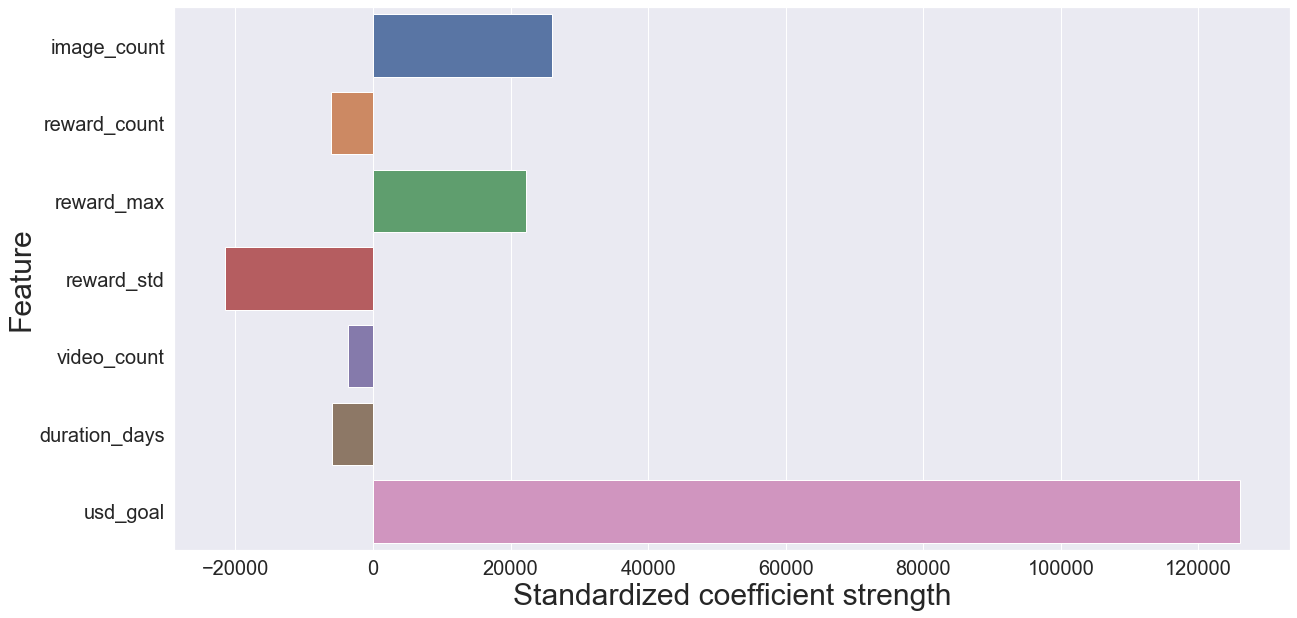

In [470]:
plt.figure(figsize=(20,10))
df_coef = pd.DataFrame([{"coef":'image_count', "val" : 26014.766450371837},
 {"coef":'reward_count', "val" :-6047.2330780242855},
 {"coef":'reward_max', "val" :22221.50519415453},
 {"coef":'reward_std', "val" :-21512.26668759315},
 {"coef":'video_count',"val" : -3699.4300031412795},
 {"coef":'duration_days', "val" :-5990.958929924538},
 {"coef":'usd_goal', "val" :125989.7528914402}])
ax = sns.barplot(x='val', y='coef', data=df_coef)
ax.set_xlabel("Standardized coefficient strength",fontsize=30)
ax.set_ylabel("Feature",fontsize=30)
ax.tick_params(labelsize=20)

In [479]:
def MAE(actuals, preds): #alternatively, mean absolute error is also in the original units
    return np.mean(np.abs(actuals-preds))

def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2)) #similar to stdev

print(RMSE(y3_3,preds3)) # this is in the units of the original problem!

print(MAE(y3_3,preds3))

2968353990.7483244
1341047254.538387


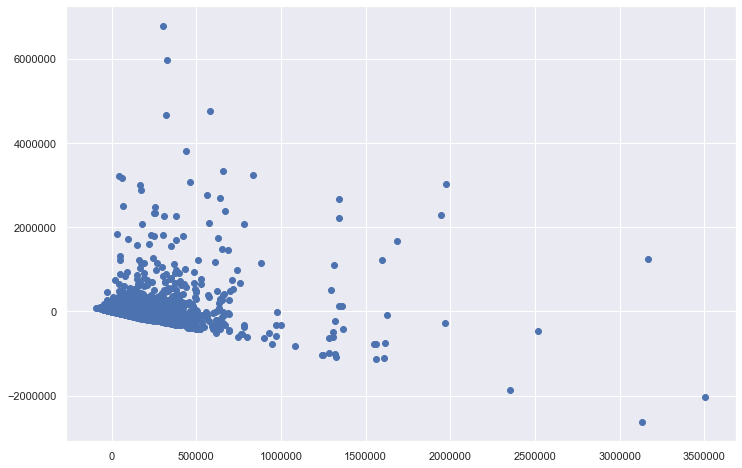

In [491]:
plt.figure(figsize=(12,8))
plt.scatter(preds3, fit.resid);

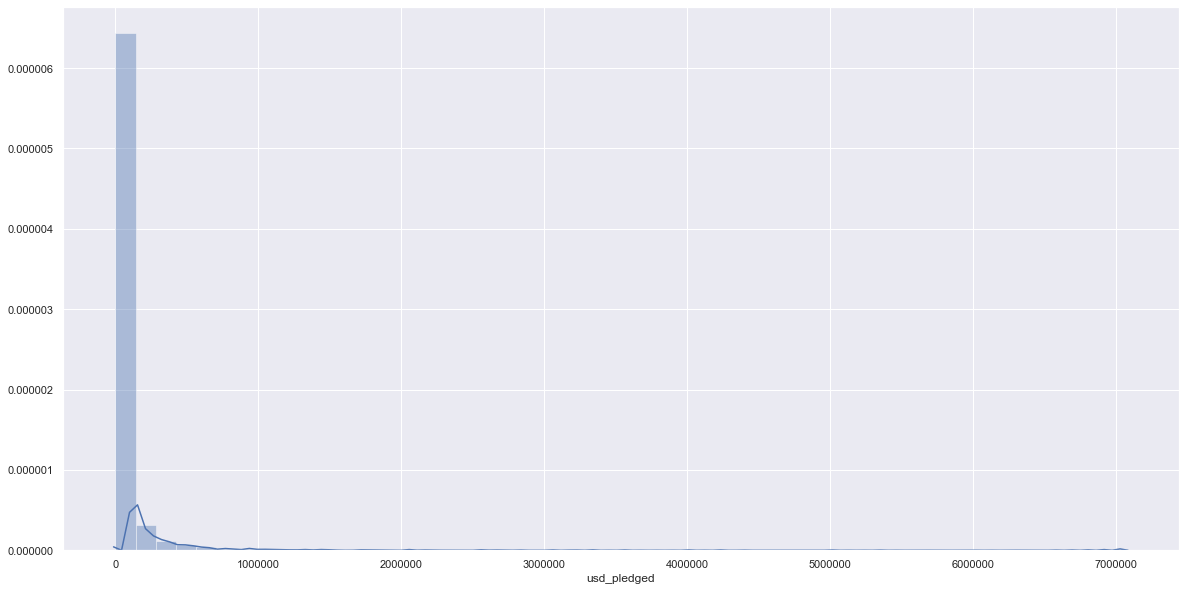

In [450]:
plt.figure(figsize=(20,10))
sns.distplot(y3_3)

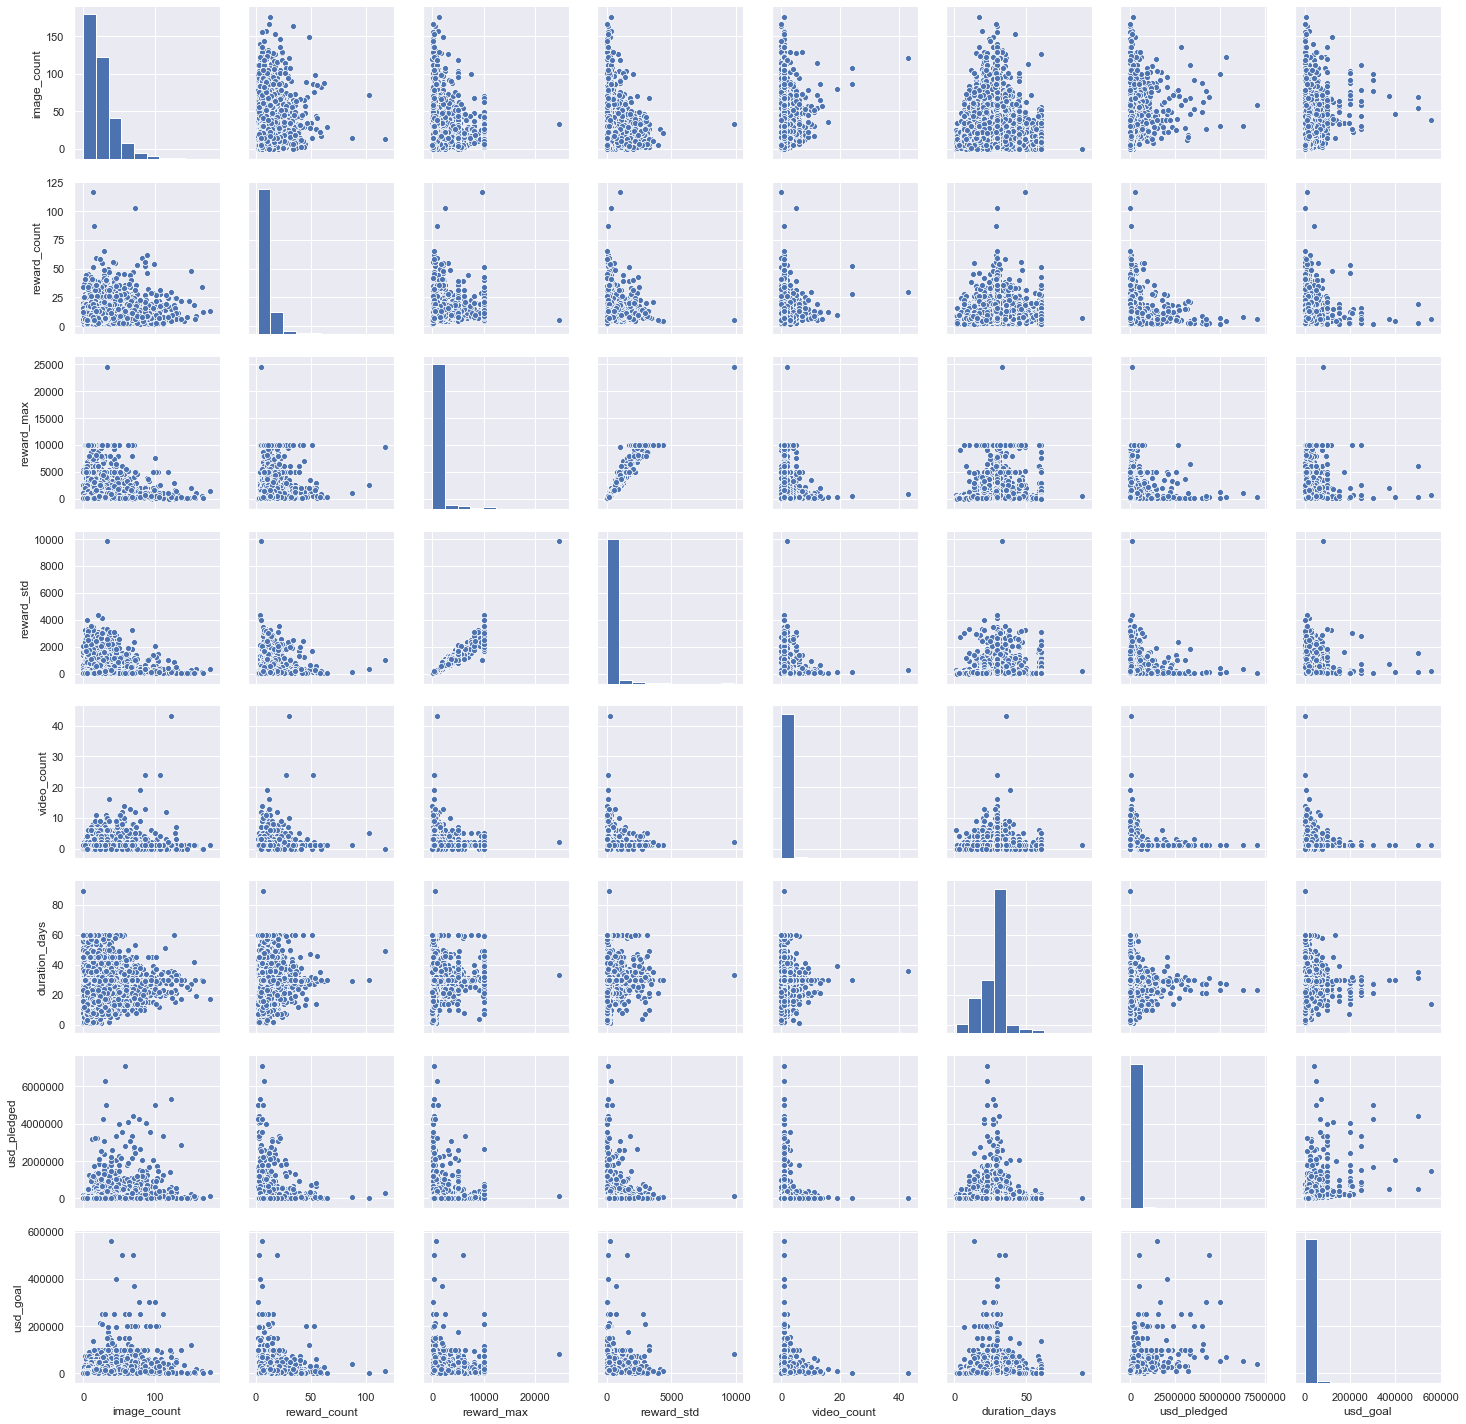

In [492]:
sns.pairplot(ks_df_4_na.drop(['profile_project_id','country', 'goal', 'staff_pick', 'pledged', 'mentions_stretch_goals', 'fx_rate', 'percent_funded', 'reward_median', 'reward_average'], axis=1))

# REMOVE GOALS

In [496]:
X3_4 = ks_df_4_na.drop(['profile_project_id','country', 'staff_pick', 'usd_pledged', 'pledged', 'percent_funded', 'reward_median', 'reward_average','fx_rate', 'usd_goal', 'goal'], axis=1)
y3_4 = ks_df_4_na['usd_pledged']
a, b, c, d = model(X3_4, y3_4)

#'mentions_stretch_goals',

Best possible Linear Regression R^2: 0.06769804128856793
K-Fold CV Linear Regression R^2: [0.06254086 0.0631694  0.05996677 0.06914107 0.07435935] mean:  0.06583548973337686
Linear Regression test R^2: 0.088
-13192.492972493805
[('image_count', 3115.5456744849143),
 ('mentions_stretch_goals', 25988.999491185936),
 ('reward_count', -1450.0223079074874),
 ('reward_max', 18.446902115777238),
 ('reward_std', -14.89512234211587),
 ('video_count', -217.43444879486142),
 ('duration_days', -327.55421579774054)]
Best possible Ridge Regression R^2: 0.06769803427974432
K-fold CV Ridge Regression R^2:  [0.06253853 0.06317342 0.05997748 0.06914187 0.07435525] mean:  0.06583730909778562
Ridge Regression test R^2: 0.088
64975.91841038605
[('image_count', 61653.82467379299),
 ('mentions_stretch_goals', 11733.255473940146),
 ('reward_count', -8586.380818476415),
 ('reward_max', 23698.41720333846),
 ('reward_std', -5344.33159404629),
 ('video_count', -218.99621282993695),
 ('duration_days', -2869.995600

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554334216778.75, tolerance: 32936401234.56134
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500284717163.5, tolerance: 32936401234.56134
  tol, rng, random, positive)


In [497]:
m = sm.OLS(y3_4,X3_4)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.130
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              224.6
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                   2.30e-312
Time:                        14:37:18   Log-Likelihood:                     -1.4607e+05
No. Observations:               10560   AIC:                                  2.922e+05
Df Residuals:                   10553   BIC:                                  2.922e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
image_count             3241.1496    126.159     25.691      0.000    2993.855    3488.444
mentions_stretch_goals  1.831e+04   5128.999      3.570      0.000    8259.225    2.84e+04
reward_count           -1809.9693    455.805     -3.971      0.000   -2703.434    -916.505
reward_max                26.6482      9.630      2.767      0.006       7.772      45.525
reward_std               -39.9952     33.404     -1.197      0.231    -105.474      25.483
video_count            -1449.9081   2281.321     -0.636      0.525   -5921.727    3021.911
duration_days           -521.6404    196.089     -2.660      0.008    -906.012    -137.269
==============================================================================
Omnibus:                    18410.312   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20895089.034
Skew:                          12.330   Prob(JB):                         0.00
Kurtosis:                     219.520   Cond. No.                     3.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

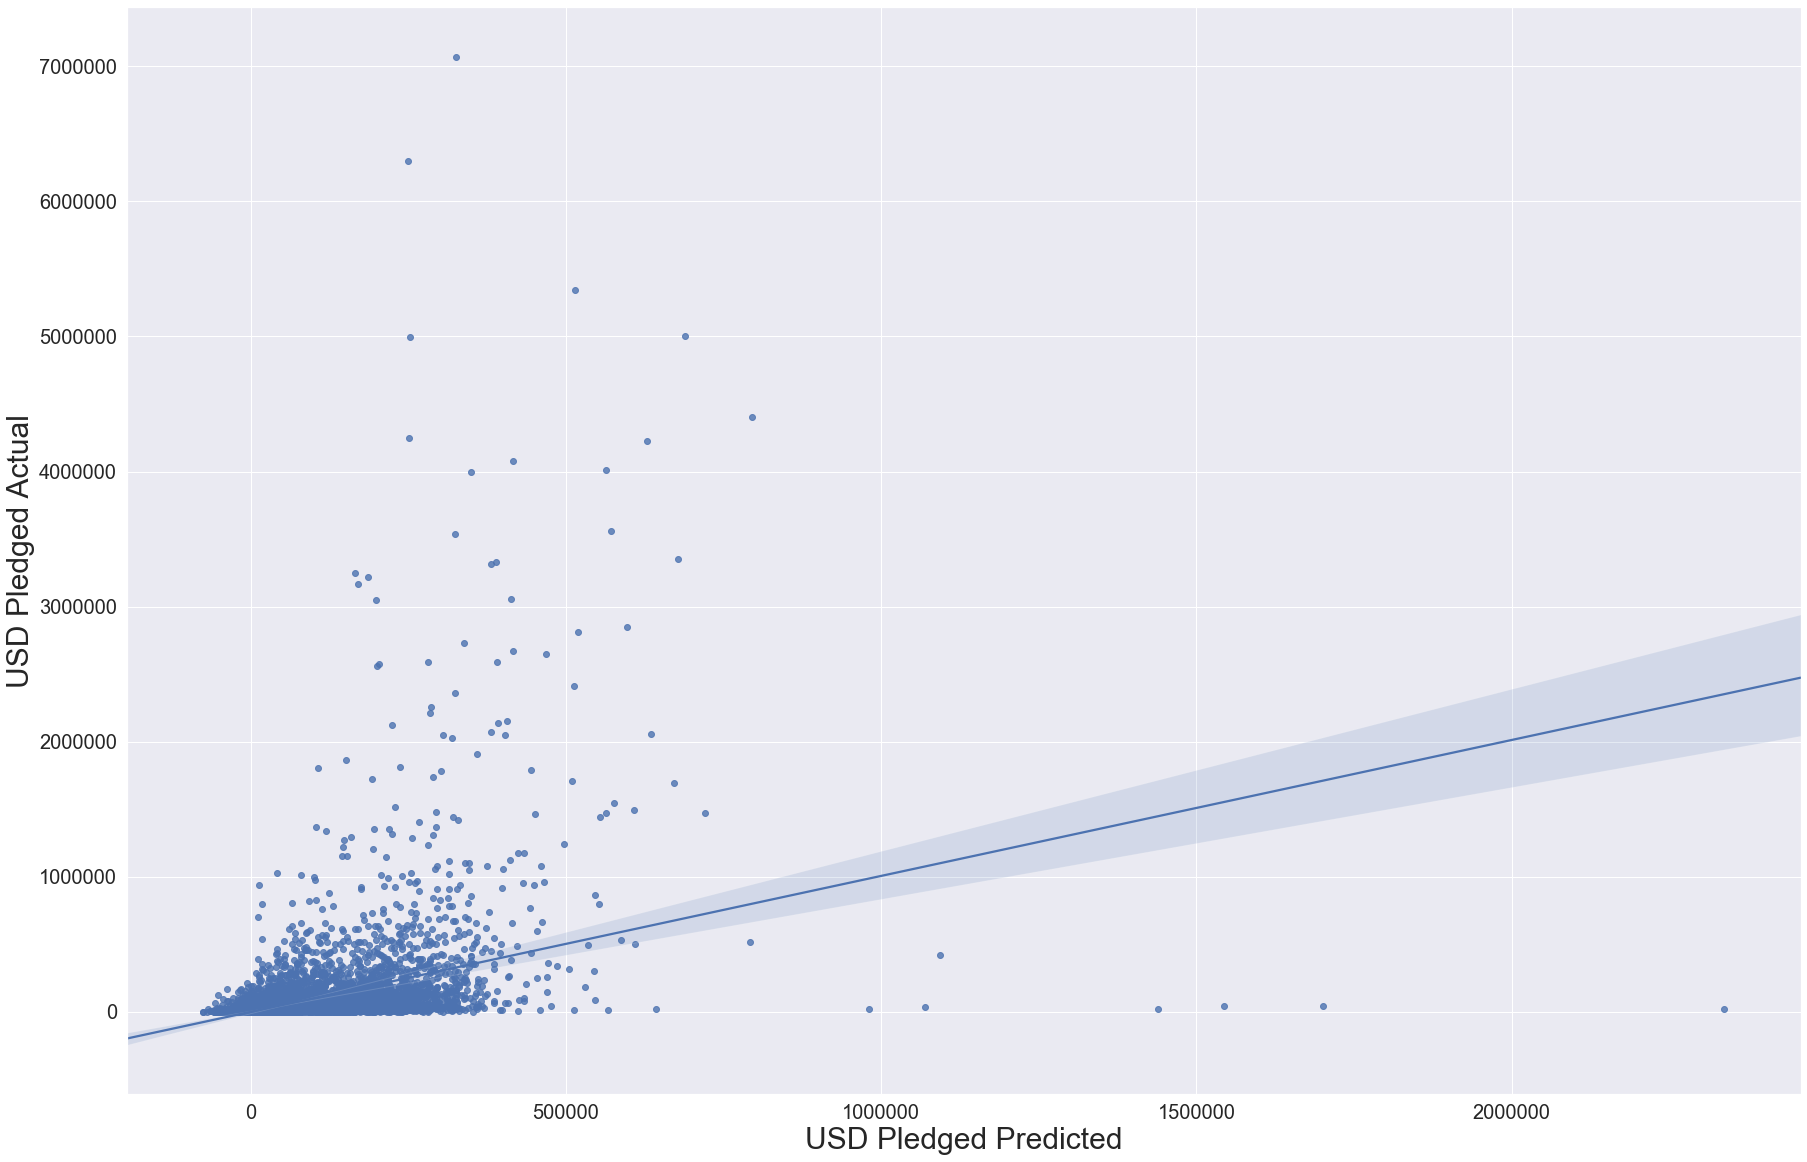

In [442]:
plt.figure(figsize=(30,20))
preds = a.predict(X3_4) # generate predictions (on training data) using fit model

#grid = sns.jointplot(preds, y3_3, kind='regplot')
ax = sns.regplot(preds, y3_4)
#grid.fig.set_figwidth(30)
#grid.fig.set_figheight(30)
ax.set_xlabel("USD Pledged Predicted",fontsize=30)
ax.set_ylabel("USD Pledged Actual",fontsize=30)
ax.tick_params(labelsize=20)

# Add Board game geek data

In [502]:
X3_5 = ks_df_4_na.drop(['profile_project_id','country', 'goal', 'staff_pick', 'pledged', 'mentions_stretch_goals', 'fx_rate', 'percent_funded', 'reward_median', 'reward_average'], axis=1)
y3_5 = ks_df_4_na['usd_pledged']


In [499]:
bgg_df = pd.read_pickle('../resources/pickles/bgg.pkl')

In [500]:
bgg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 32 columns):
bgg_average_rating           1198 non-null float64
bgg_avg_complex_weight       770 non-null float64
bgg_categories               963 non-null object
bgg_categories_count         976 non-null float64
bgg_category                 222 non-null object
bgg_expansions               976 non-null float64
bgg_families                 793 non-null object
bgg_families_count           976 non-null float64
bgg_genre                    222 non-null object
bgg_integrations             976 non-null float64
bgg_is_compilation           976 non-null float64
bgg_is_reimplementation      976 non-null float64
bgg_mechanics                1138 non-null object
bgg_mechanics_count          1198 non-null int64
bgg_poll_best_age            528 non-null object
bgg_poll_best_num_players    629 non-null object
bgg_prod_team_size           1198 non-null int64
bgg_rpg_id                   222 non-null object
b

In [501]:
rpg_df = bgg_df[bgg_df['bgg_type'] == 'rpgitem']
bg_df = bgg_df[bgg_df['bgg_type'] == 'boardgame']

In [ ]:
bg_df.uni

In [503]:
ks_bg = bg_df.merge(X3_5, how='left', left_on='profile_project_id', right_on='profile_project_id')


KeyError: 'profile_project_id'

In [34]:
ks_bg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 0 to 969
Data columns (total 82 columns):
bgg_average_rating           970 non-null float64
bgg_avg_complex_weight       735 non-null float64
bgg_categories               957 non-null object
bgg_categories_count         970 non-null float64
bgg_category                 0 non-null object
bgg_expansions               970 non-null float64
bgg_families                 788 non-null object
bgg_families_count           970 non-null float64
bgg_genre                    0 non-null object
bgg_integrations             970 non-null float64
bgg_is_compilation           970 non-null float64
bgg_is_reimplementation      970 non-null float64
bgg_mechanics                928 non-null object
bgg_mechanics_count          970 non-null int64
bgg_poll_best_age            525 non-null object
bgg_poll_best_num_players    625 non-null object
bgg_prod_team_size           970 non-null int64
bgg_rpg_id                   0 non-null object
bgg_rpg_val  

2.086372517006803

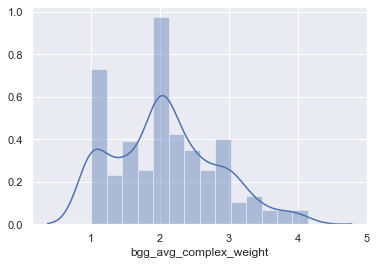

In [38]:
sns.distplot(ks_bg['bgg_avg_complex_weight'].dropna())
ks_bg['bgg_avg_complex_weight'].dropna().mean()

# y = USD Pledged

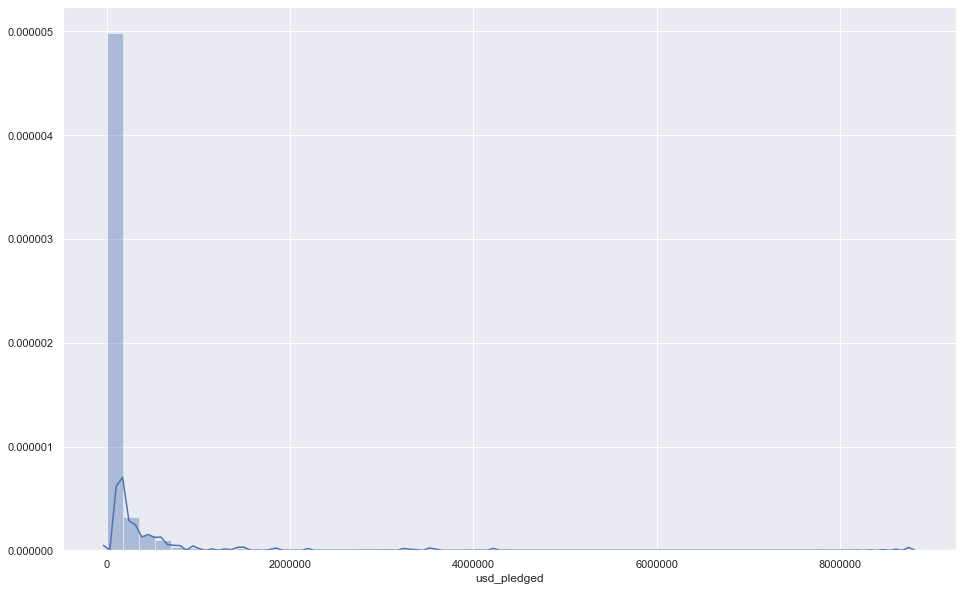

In [453]:
plt.figure(figsize=(16,10))
sns.distplot(ks_bg['usd_pledged'])

In [80]:
ks_bg['usd_pledged'].describe()

count    9.700000e+02
mean     1.148025e+05
std      4.251864e+05
min      1.430000e+02
25%      9.900915e+03
50%      2.407092e+04
75%      7.020829e+04
max      8.782572e+06
Name: usd_pledged, dtype: float64

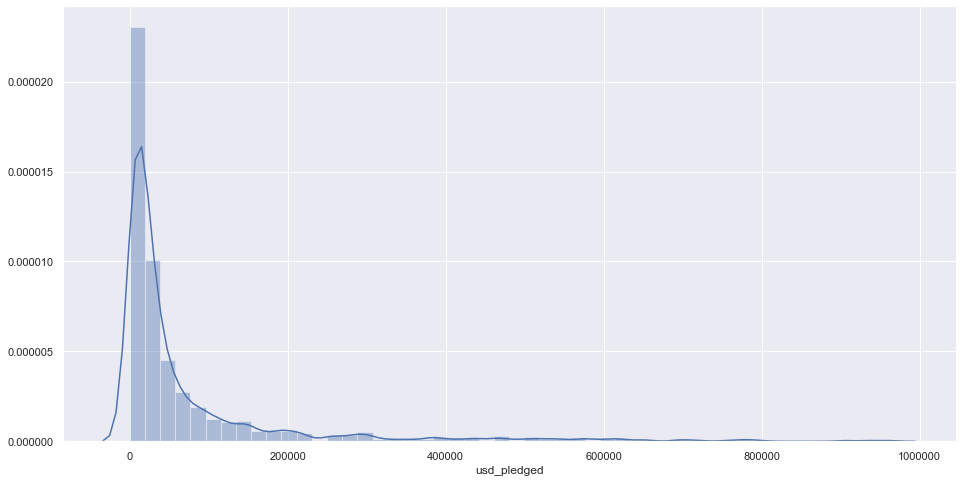

In [82]:
plt.figure(figsize=(12,8))
sns.distplot(ks_bg[ks_bg['usd_pledged'] < 1000000]['usd_pledged'])


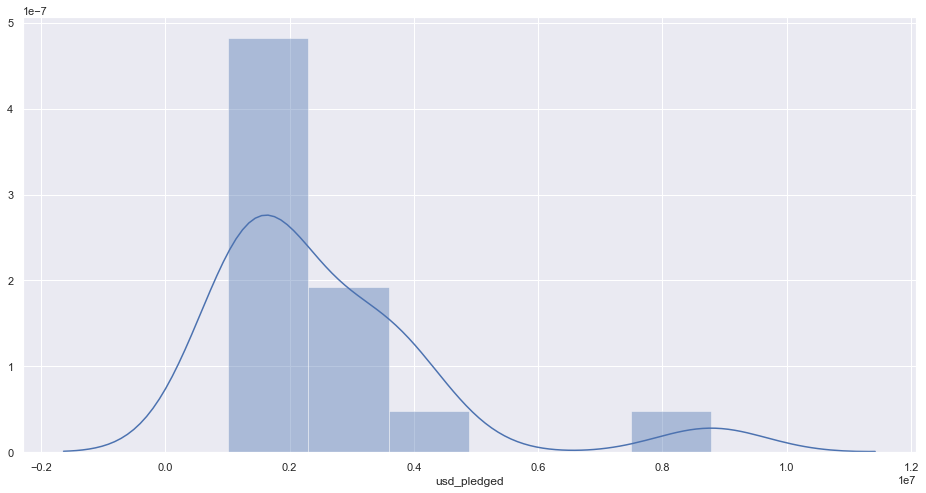

In [83]:
plt.figure(figsize=(16,8))
sns.distplot(ks_bg[ks_bg['usd_pledged'] >= 1000000]['usd_pledged'])

In [204]:
ks_bg.sort_values(by='usd_pledged', ascending=False).head(20)

bgg_average_rating  bgg_avg_complex_weight  \
820             5.96810                  1.0757   
608             7.96616                  3.2723   
804             7.35269                  2.5370   
175             6.66667                  1.0000   
464             6.66667                  3.0000   
164             6.46265                  1.0667   
315             7.99326                  3.3546   
764             6.40008                  1.5143   
7               8.27282                  3.3770   
784             7.58809                  2.5000   
181             7.58770                  1.6898   
873             8.12843                  3.3478   
121             7.94666                  3.1159   
654             8.42600                  3.3514   
934             8.21591                  2.3333   
952             8.05717                  2.8750   
483             7.33735                  2.3333   
915             7.34615                     NaN   
753             8.01645                  2.8795   
395             7.97021                  2.0603   

                                        bgg_categories  bgg_categories_count  \
820  bg_cat Animals,bg_cat Card Game,bg_cat Comic B...                   4.0   
608  bg_cat Bluffing,bg_cat Fantasy,bg_cat Miniatur...                   6.0   
804  bg_cat Adventure,bg_cat Exploration,bg_cat Fan...                   5.0   
175                                  bg_cat Party Game                   1.0   
464  bg_cat Card Game,bg_cat Fantasy,bg_cat Novel-b...                   4.0   
164  bg_cat Card Game,bg_cat Comic Book / Strip,bg_...                   5.0   
315  bg_cat Ancient,bg_cat Civilization,bg_cat Myth...                   5.0   
764    bg_cat Card Game,bg_cat Humor,bg_cat Party Game                   3.0   
7    bg_cat Economic,bg_cat Fighting,bg_cat Science...                   4.0   
784                   bg_cat Fantasy,bg_cat Miniatures                   2.0   
181  bg_cat Bluffing,bg_cat Card Game,bg_cat Deduct...                   7.0   
873  bg_cat Adventure,bg_cat Fighting,bg_cat Horror...                   5.0   
121  bg_cat Fantasy,bg_cat Fighting,bg_cat Horror,b...                   4.0   
654  bg_cat Bluffing,bg_cat Card Game,bg_cat Fantas...                   5.0   
934  bg_cat Adventure,bg_cat Exploration,bg_cat Fan...                   6.0   
952                               bg_cat Environmental                   1.0   
483  bg_cat Miniatures,bg_cat Science Fiction,bg_ca...                   3.0   
915  bg_cat Adventure,bg_cat Fighting,bg_cat Miniat...                   5.0   
753  bg_cat Fantasy,bg_cat Fighting,bg_cat Miniatur...                   4.0   
395  bg_cat Adventure,bg_cat Deduction,bg_cat Murde...                   3.0   

    bgg_category  bgg_expansions  \
820          NaN             4.0   
608          NaN             6.0   
804          NaN            13.0   
175          NaN             0.0   
464          NaN             0.0   
164          NaN             8.0   
315          NaN             7.0   
764          NaN             9.0   
7            NaN            16.0   
784          NaN             4.0   
181          NaN             0.0   
873          NaN            13.0   
121          NaN            47.0   
654          NaN             9.0   
934          NaN             6.0   
952          NaN             6.0   
483          NaN             1.0   
915          NaN             5.0   
753          NaN             5.0   
395          NaN             6.0   

                                          bgg_families  bgg_families_count  \
820  bg_fam Animals: Cats,bg_fam Card Games: Matchi...                 3.0   
608  bg_fam Admin: Better Description Needed!,bg_fa...                 7.0   
804  bg_fam Admin: Better Description Needed!,bg_fa...                 5.0   
175  bg_fam Admin: Unreleased Games,bg_fam Crowdfun...                 2.0   
464                                               None                 0.0   
164                   bg_fa

In [1]:
ks_bg.groupby('bgg_categories').count()

NameError: name 'ks_bg' is not defined

In [206]:
small_df = ks_bg[[
#     'launched_monday',
#     'launched_tuesday',
#     'launched_wednesday', 
#     'launched_thursday', 
#     'launched_friday', 
#     'launched_saturday', 
#     'launched_sunday',
#     'deadline_monday',
#     'deadline_tuesday',
#     'deadline_wednesday', 
#     'deadline_thursday', 
#     'deadline_friday', 
#     'deadline_saturday', 
#     'deadline_sunday',
    'staff_pick',
    
    'goal',
    'bgg_average_rating',
    'bgg_categories_count',
    'bgg_mechanics_count',
    'bgg_prod_team_size',
    'duration_days',
    'bgg_avg_complex_weight',
    
    'usd_pledged'
   ]].dropna()
small_df.sample(3)



# for categorical, check if there's a cutoff off frequency and combine into other
# look into regularization


staff_pick      goal  bgg_average_rating  bgg_categories_count  \
554           1  500000.0             6.66087                   4.0   
424           0    5000.0             6.72935                   2.0   
642           0   22222.0             6.08571                   2.0   

     bgg_mechanics_count  bgg_prod_team_size  duration_days  \
554                    6                   7             35   
424                    2                   7             25   
642                    3                   3             31   

     bgg_avg_complex_weight    usd_pledged  
554                  2.7708  518538.380000  
424                  1.8000    7481.991953  
642                  1.5000    3985.120340

In [207]:
smaller_df = small_df[small_df['usd_pledged'] < 1000000]
smaller_df

staff_pick      goal  bgg_average_rating  bgg_categories_count  \
0             1   35000.0             6.64623                   3.0   
1             0     500.0             5.49312                   3.0   
2             1   20000.0             7.04886                   1.0   
3             0   45000.0             8.38750                   6.0   
4             0    5000.0             8.12500                   4.0   
5             0   12000.0             6.95803                   2.0   
6             0   35000.0             6.63462                   2.0   
8             0    1000.0             6.35143                   3.0   
11            0   35000.0             8.85000                   3.0   
12            1   25000.0             7.09133                   3.0   
13            0   10000.0             6.85556                   4.0   
14            1    9000.0             6.20000                   1.0   
15            0   10000.0             7.03279                   2.0   
17            0    5000.0             6.62500                   2.0   
18            0    4000.0             8.54348                   4.0   
19            1    7500.0             6.20000                   3.0   
20            0   12000.0             6.76667                   2.0   
21            0     500.0             7.23529                   5.0   
22            1   30000.0             6.32500                   2.0   
23            0     250.0             5.33333                   2.0   
24            1    6000.0             8.25000                   2.0   
25            0    6000.0             5.20238                   4.0   
27            1   50000.0             7.73275                   2.0   
28            0   10000.0             6.07270                   1.0   
29            0    1000.0             4.50000                   4.0   
31            0   30000.0             7.63490                   5.0   
32            1    5000.0             7.29464                   3.0   
33            0    6000.0             7.10000                   5.0   
35            0    7717.0             7.41867                   4.0   
36            1   80000.0             8.71625                   3.0   
..          ...       ...                 ...                   ...   
930           1    4000.0             5.84899                   1.0   
931           0   15000.0             6.18000                   5.0   
932           0    9500.0             5.43707                   2.0   
933           0    5000.0             7.01346                   2.0   
935           0    8000.0             6.90834                   5.0   
936           0    2500.0             7.57500                   2.0   
937           0    1000.0             6.72066                   2.0   
938           1    9000.0             6.41713                   4.0   
941           0    2500.0             6.44376                   3.0   
942           0   18000.0             7.54295                   2.0   
943           0    3000.0             6.39357                   2.0   
944           0   15000.0             7.12710                   3.0   
946           0   10000.0             7.36040                   5.0   
947           0     760.0             6.61538                   4.0   
948           0     500.0             7.48247                   2.0   
950           1    7500.0             7.07622                   5.0   
951           0   50000.0             8.66364                   2.0   
953           0    4000.0             6.00000                   3.0   
954           1   20000.0             5.53913                   2.0   
955           0  165000.0             7.82222                   4.0   
957           0    8000.0             7.22169                   4.0   
958           0    3000.0             7.23750                   1.0   
959           1   20000.0             7.48404                   1.0   
960           0   35000.0             7.65714                   2.0   
961           1   10000.0    

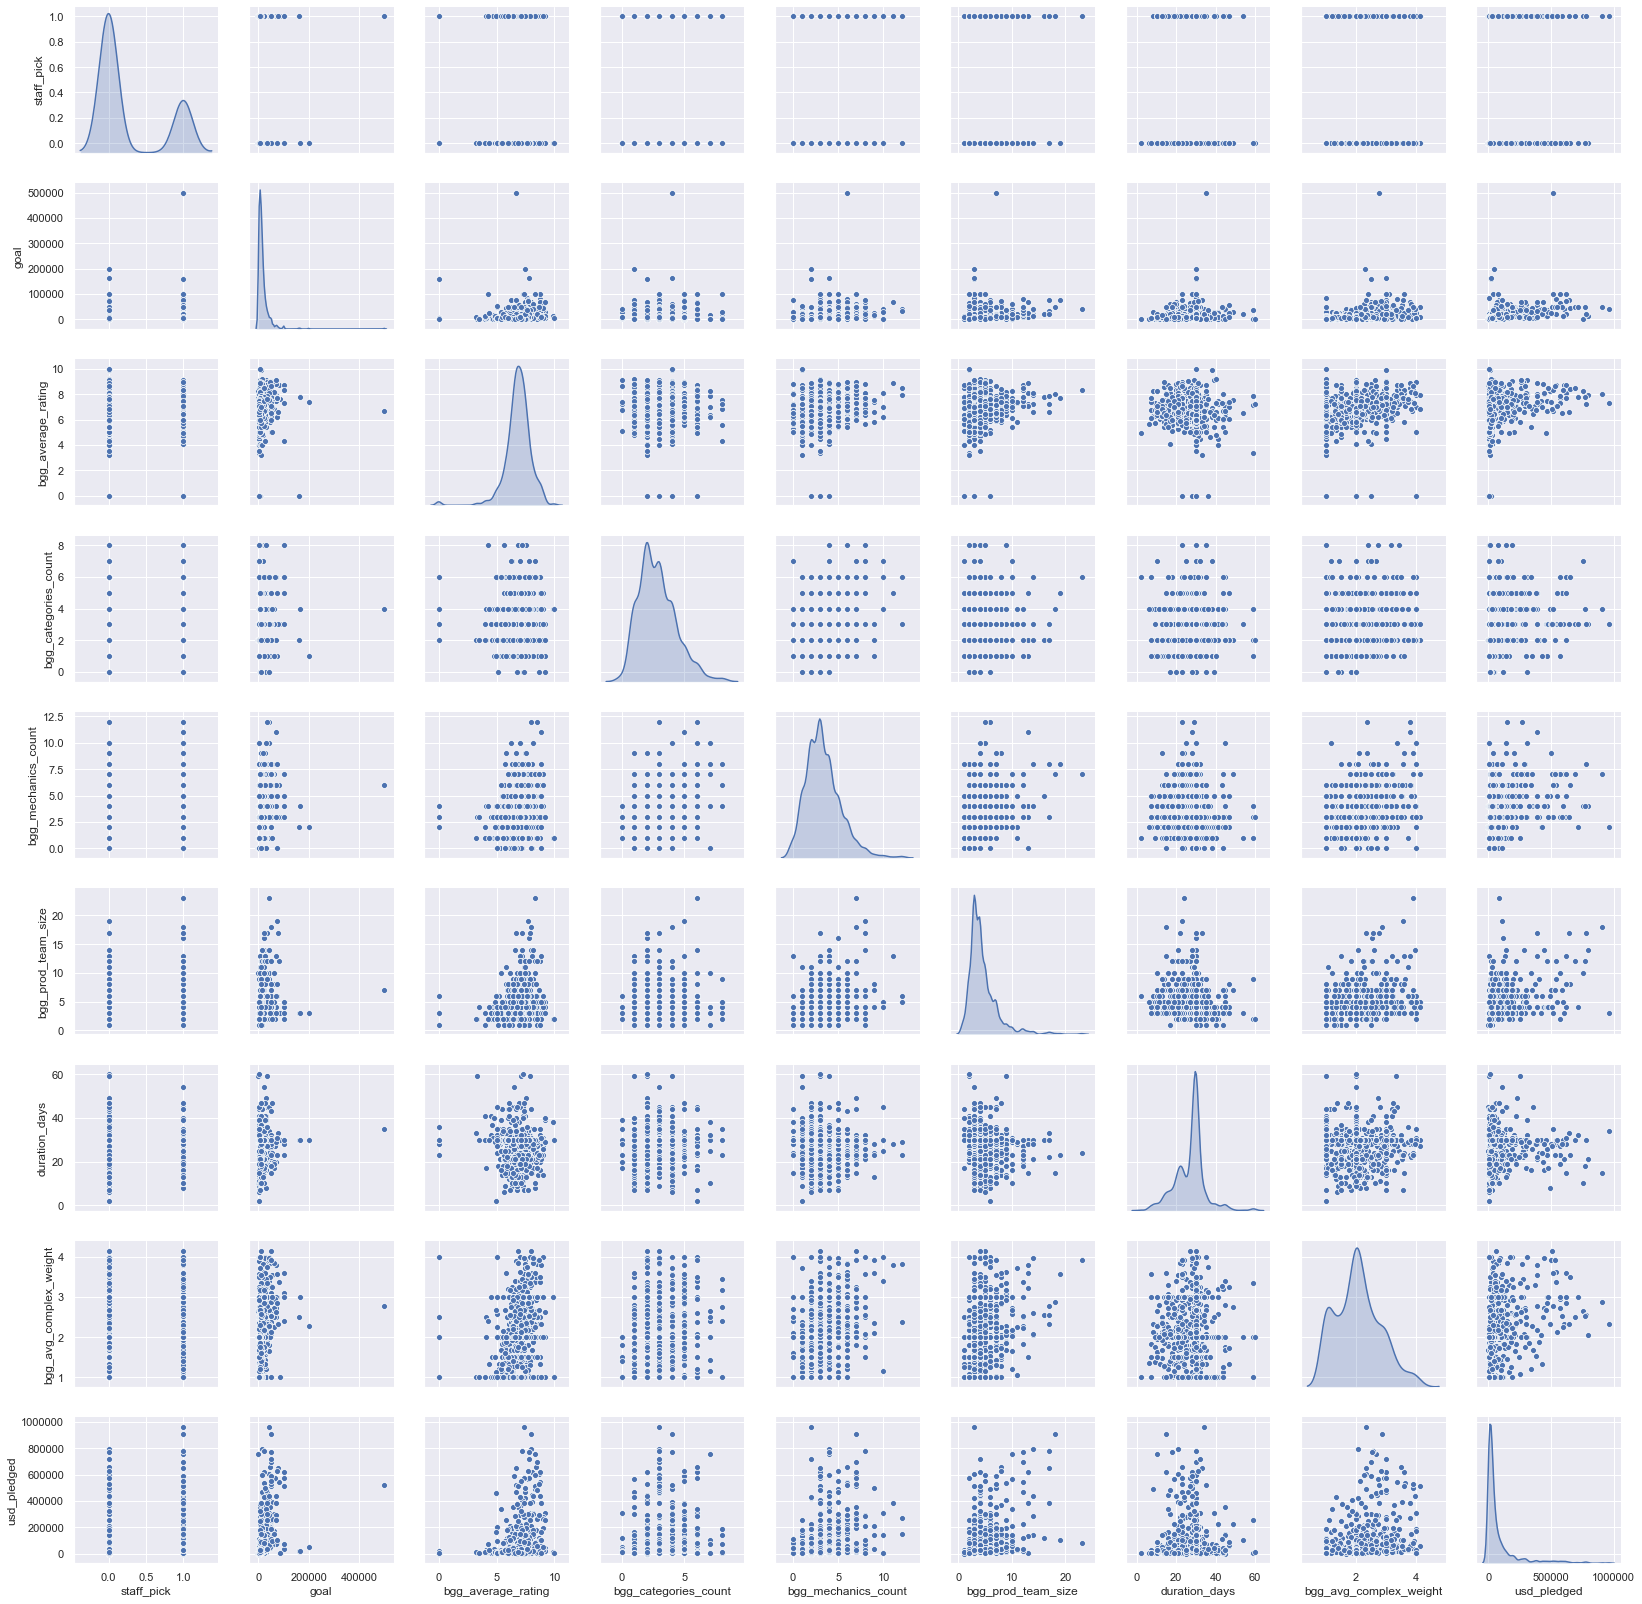

In [208]:
sns.pairplot(smaller_df, diag_kind='kde')

In [209]:
X = smaller_df.drop(['usd_pledged'], axis=1)
y = smaller_df['usd_pledged']

# Modeling

In [ ]:
X_train, X_val, y, y_val = train_test_split(X, y, test_size=0.25)

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_val, y_val))

In [ ]:
poly = PolynomialFeatures()

X_train = poly.fit_transform(X_train)
X_val = poly.fit_transform(X_val)
X_test = poly.transform(X_test)

# Cross Validation

In [19]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.25)

# Linear
# score on train to get upper bound
lm = LinearRegression()
lm.fit(X_cv, y_cv)
print("Best possible Linear Regression R^2:", lm.score(X_cv, y_cv))

lm = LinearRegression()
cv_scores = cross_val_score(lm, X_cv, y_cv, # estimator, features, target
                              cv=5, # number of folds 
                              scoring='r2') # scoring metric

print('K-Fold CV Linear Regression R^2:',  cv_scores, "mean: ", np.mean(cv_scores))
lm.fit(X_cv,y_cv)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

# Poly
lm_poly = LinearRegression()
print('K fold Polynomial Regression R^2: ', 
      np.mean(cross_val_score(lm, X, y, # estimator, features, target
                              cv=5, # number of folds 
                              scoring='r2'))) # scoring metric


NameError: name 'X' is not defined

K-Fold CV Linear Regression R^2: [0.28135917 0.44234261 0.29636856 0.25983104 0.1674714 ] mean:  0.2894745579692221
Linear Regression test R^2: 0.240


In [ ]:
lm_poly = LinearRegression()
print('K fold Polynomial Regression R^2: ', 
      np.mean(cross_val_score(lm, X, y, # estimator, features, target
                              cv=5, # number of folds 
                              scoring='r2'))) # scoring metric

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [73]:
m = sm.OLS(y,X)
fit = m.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            usd_pledged   R-squared (uncentered):                   0.228
Model:                            OLS   Adj. R-squared (uncentered):              0.222
Method:                 Least Squares   F-statistic:                              35.90
Date:                Thu, 10 Oct 2019   Prob (F-statistic):                    3.72e-38
Time:                        13:18:12   Log-Likelihood:                         -10596.
No. Observations:                 735   AIC:                                  2.120e+04
Df Residuals:                     729   BIC:                                  2.123e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
goal                       5.1365      0.577      8.907      0.000       4.004       6.269
bgg_average_rating      8849.6155   1.01e+04      0.875      0.382    -1.1e+04    2.87e+04
bgg_categories_count    2.729e+04   1.12e+04      2.447      0.015    5395.319    4.92e+04
staff_pick              1.695e+05   3.69e+04      4.597      0.000    9.71e+04    2.42e+05
duration_days          -3278.1540   1874.361     -1.749      0.081   -6957.944     401.636
bgg_avg_complex_weight -2.471e+04    2.4e+04     -1.028      0.304   -7.19e+04    2.25e+04
==============================================================================
Omnibus:                     1305.416   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1224146.823
Skew:                          11.484   Prob(JB):                         0.00
Kurtosis:                     201.607   Cond. No.                     8.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# y = percent_funded